# PCA and Clustering - Topic Sentiment and Prevalence

### Import Libraries

In [222]:
import pandas as pd
import numpy as np

from data.time_series_functions import vs_previous_high
from data.db_interaction import DatabaseInteraction

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from datetime import datetime, timedelta
from itertools import product, combinations
from collections import Counter
from math import ceil

import pickle

### Import Data

In [223]:
# Import article data
with open('sentiment_pickles/pickle_articles_modeling.pickle', 'rb') as read_file:
    articles_df = pickle.load(read_file)

In [224]:
# Import article data
with open('sentiment_pickles/pickle_topics_by_article.pickle', 'rb') as read_file:
    topics_by_article = pickle.load(read_file)

### Calculate News Article Polarity and Subjectivity (VADER)

In [225]:
# Calculate polarity and subjectivity by article
articles_df['polarity'] = articles_df.apply(lambda row: TextBlob(row['body']).sentiment.polarity, axis=1)
articles_df['subjectivity'] = articles_df.apply(lambda row: TextBlob(row['body']).sentiment.subjectivity, axis=1)

In [226]:
# Group by date to find a daily mean polarity and subjectivity
articles_grouped = articles_df.groupby('date')[['polarity', 'subjectivity']].mean()

### Concatenate Topic Model Breakdown to Articles DataFrame

In [227]:
# Update column names for topic model
new_columns = []
for col in list(topics_by_article.columns):
    new_columns.append('topic_' + str(col + 1))

topics_by_article.columns = new_columns

# Add topic distributions to the articles df
articles_df = pd.concat([articles_df.reset_index(drop=True), topics_by_article.reset_index(drop=True)], axis=1)

In [228]:
# Create daily average dataframe, all features
daily_avg_df = articles_df.groupby('date').mean()

In [229]:
# Create daily topic breakdown dataframe (no other features)
daily_avg_by_topic = daily_avg_df.iloc[:, -1 * len(new_columns):]

# Clustering Dates By Topic Breakdown

#### *Create and Scale Cluster Data*

In [230]:
# Display all available columns
daily_avg_by_topic.columns

Index(['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12',
       'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18',
       'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24',
       'topic_25'],
      dtype='object')

In [231]:
# Standard scale the data
st_scale = StandardScaler()
daily_avg_by_topic_st = st_scale.fit_transform(daily_avg_by_topic)

#### *Determine Optimal PCA Components*

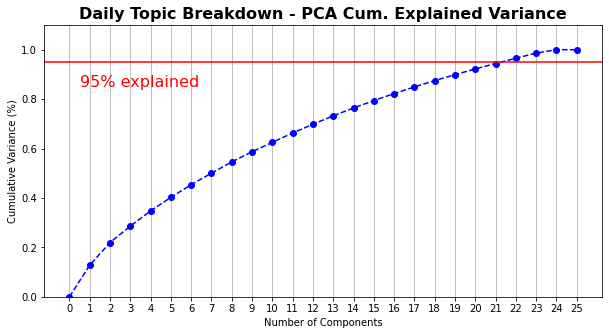

In [232]:
# Determine number of PCA components
pca_daily_topics = PCA(len(new_columns)).fit(daily_avg_by_topic_st) # include number of features for test

# Plot PCA components and cumulative explained variance
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(0, len(new_columns) + 1, step=1)
y = np.cumsum(np.insert(pca_daily_topics.explained_variance_ratio_, 0, 0))

plt.ylim(0.0,1.1)
plt.plot(x, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(new_columns) + 1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Variance (%)')
plt.title('Daily Topic Breakdown - PCA Cum. Explained Variance', fontsize=16, fontweight='bold')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% explained', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [233]:
# Display variance explained in a dataframe
pd.DataFrame({'Components' : x, 'Cum. Variance' : y}).sort_values('Components', ascending=False)\
    .style.format({'Cum. Variance' : '{:0.1%}'})

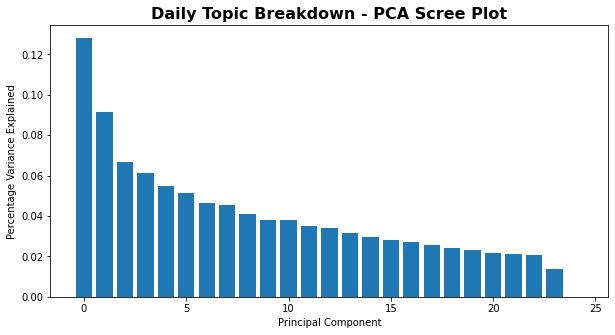

In [234]:
# Display Scree plot
fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(0, len(new_columns), step=1)
y = pca_daily_topics.explained_variance_ratio_

plt.bar(x, y)
plt.title('Daily Topic Breakdown - PCA Scree Plot', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Percentage Variance Explained')
plt.show()

In [235]:
# Display variance explained in a dataframe
pd.DataFrame({'Components' : x, 'Variance Explained' : y}).sort_values('Components')\
    .style.format({'Variance Explained' : '{:0.1%}'})

#### *Run PCA and K-Means Clustering*

In [236]:
# Rebuild PCA witth chosen number of components
pca_daily_topics = PCA(21)

#Transform the clustering data
daily_avg_by_topic_pca = pca_daily_topics.fit_transform(daily_avg_by_topic_st)

In [237]:
# Create K-Means model and make predictions
km = KMeans(n_clusters=6)
y_predicted = km.fit_predict(daily_avg_by_topic_pca)

In [238]:
# Add predictions to the data and show mean for each cluster and feature combination
daily_avg_by_topic['cluster'] = y_predicted
daily_avg_by_topic.groupby('cluster').mean()

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
cluster                                                                         
0        0.046450  0.055003  0.012644  0.009226  0.084939  0.036547  0.068264   
1        0.032112  0.032247  0.010918  0.012855  0.032299  0.029807  0.199586   
2        0.054788  0.062433  0.010866  0.009927  0.048072  0.048378  0.050503   
3        0.043007  0.034665  0.045766  0.029908  0.051971  0.082746  0.072745   
4        0.036581  0.024476  0.008880  0.008848  0.058242  0.030944  0.146794   
5        0.073679  0.030460  0.011434  0.010045  0.065203  0.062217  0.058712   

          topic_8   topic_9  topic_10  ...  topic_16  topic_17  topic_18  \
cluster                                ...                                 
0        0.024361  0.033902  0.027236  ...  0.027576  0.039420  0.035460   
1        0.068957  0.011562  0.032143  ...  0.027572  0.015979  0.019172   
2        0.012696  0.011317  0.025149  ...  0.021627  0.029915  0.021720   
3        0.023260  0.020641  0.030104  ...  0.029651  0.023603  0.031570   
4        0.036975  0.005221  0.038876  ...  0.021497  0.015579  0.029466   
5        0.015044  0.011097  0.031931  ...  0.021595  0.036170  0.023143   

         topic_19  topic_20  topic_21  topic_22  topic_23  topic_24  topic_25  
cluster                                                                        
0        0.081710  0.030151  0.040211  0.036836  0.050667  0.015739  0.026338  
1        0.045129  0.031225  0.024450  0.090239  0.037565  0.008377  0.028347  
2        0.016224  0.020188  0.054773  0.038612  0.041640  0.126059  0.058063  
3        0.054415  0.024842  0.041110  0.037143  0.053609  0.015198  0.032647  
4        0.028974  0.098591  0.036718  0.097295  0.028706  0.006050  0.035164  
5        0.028749  0.024109  0.074803  0.051077  0.042728  0.018161  0.060271  

[6 rows x 25 columns]

#### *Visualize K-Means Clusters*

In [239]:
x = daily_avg_by_topic_pca[:, 0]
y = daily_avg_by_topic_pca[:, 1]
z = daily_avg_by_topic_pca[:, 2]

colors = {0 : 'red',
          1 : 'green',
          2 : 'blue',
          3 : 'aqua',
          4 : 'purple',
          5 : 'orange'
         }

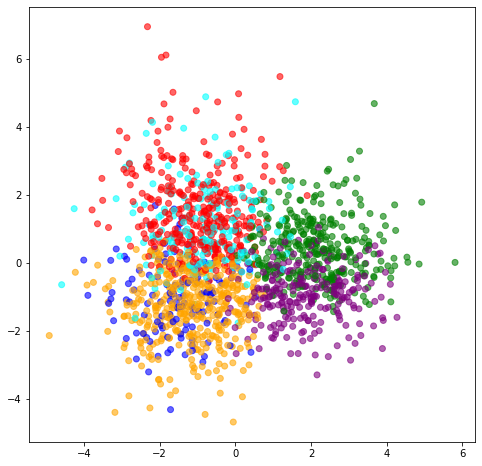

In [240]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(x, y, c=pd.Series(y_predicted).map(colors), alpha=0.6)
plt.show()

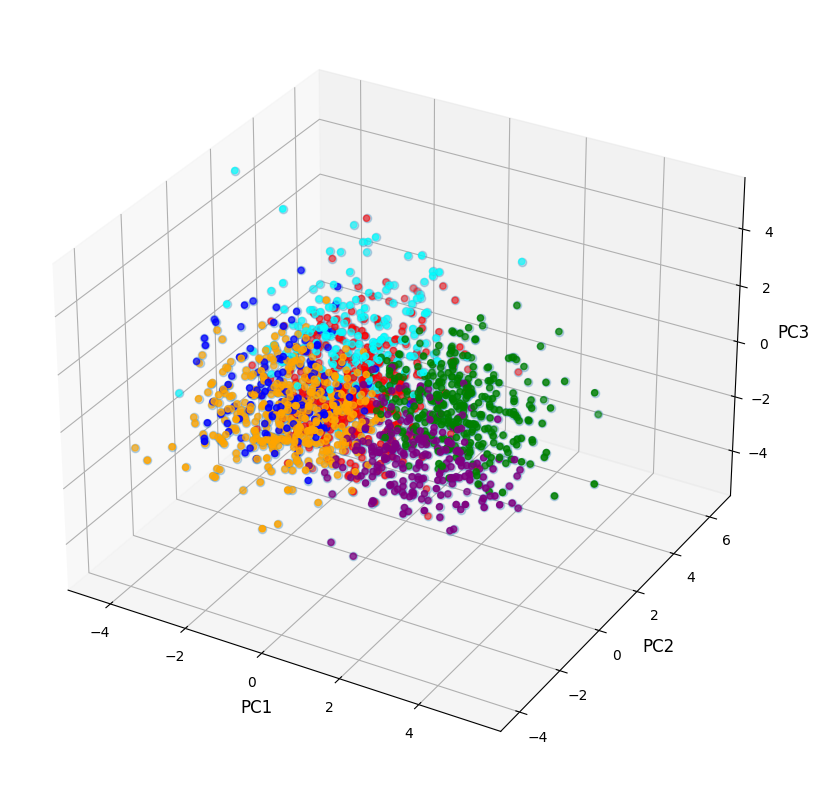

In [241]:
# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, linestyle='none', marker='o', alpha=0.25)
ax.scatter(x, y, z, c=pd.Series(y_predicted).map(colors))
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.axes.set_xlim3d(left=x.min(), right=x.max()) 
ax.axes.set_ylim3d(bottom=y.min(), top=y.max()) 
ax.axes.set_zlim3d(bottom=z.min(), top=z.max()) 
ax.view_init(elev=30)#, azim=0)

fig.tight_layout()

In [ ]:
# Create 360 images for GIF
for i in np.arange(0, 360, 1):
    ax.view_init(elev=16, azim=i)
    fig.savefig('regression_image%d.png' % i)

## One vs. Rest Plots - Dates by Topic

In [242]:
def one_vs_rest_kde(data, cluster_col, cluster_val, viz_cols, title):
    """
    Accept a dataset (cluster column LAST) and a cluster value.
    Display one vs. rest distributions for all metrics in the data.
    """
    
    cols = data.columns[:-1]
    viz_rows = ceil(len(cols) / viz_cols)
    
    data[cluster_col] = np.where(data[cluster_col] == cluster_val, str(cluster_val), 'REST')
    
    fig, axes = plt.subplots(viz_rows, viz_cols, figsize=[16, viz_rows * 3])
    fig.tight_layout(pad=5.0)
    fig.suptitle(title, fontsize=22, fontweight='bold')
    fig.subplots_adjust(top=0.9)

    for i in range(len(cols)):
        plt.subplot(viz_rows, viz_cols, i + 1)
        sns.kdeplot(data=data, x=cols[i], hue=cluster_col, common_norm=True, 
                    hue_order=['REST', str(cluster_val)])
        plt.xlabel('')
        plt.ylabel('')
        plt.title(cols[i])

In [243]:
def one_vs_rest_table(data, cluster_col, cluster_val):
    """
    Accept a dataset (cluster column LAST) and a cluster value.
    Display one vs. rest describe tables for all metrics in the data.
    """
    cluster = data[data[cluster_col] == cluster_val].describe().T.loc[:, ['mean', 'std', 'min', 'max']]
    rest = data[data[cluster_col] != cluster_val].describe().T.loc[:, ['mean', 'std', 'min', 'max']]
    
    combined = cluster.merge(rest , left_index=True, right_index=True).iloc[:-1]
    combined.columns = ['Cluster Mean', 'Cluster STD', 'Cluster Min', 'Cluster Max', 'Rest Mean', 'Rest STD', 'Rest Min', 'Rest Max']
    
    combined['Mean Difference'] = combined['Cluster Mean'] - combined['Rest Mean']
    combined['Mean Difference (ABS)'] = np.abs(combined['Mean Difference'])
    combined['STD Difference'] = combined['Cluster STD'] - combined['Rest STD']
    combined = combined.sort_values('Mean Difference (ABS)', ascending=False)
    
    combined = combined[['Mean Difference', 'STD Difference',      
                         'Cluster Mean', 'Rest Mean', 'Cluster STD', 'Rest STD',
                         'Cluster Min', 'Cluster Max', 'Rest Min', 'Rest Max']]
    
    return combined

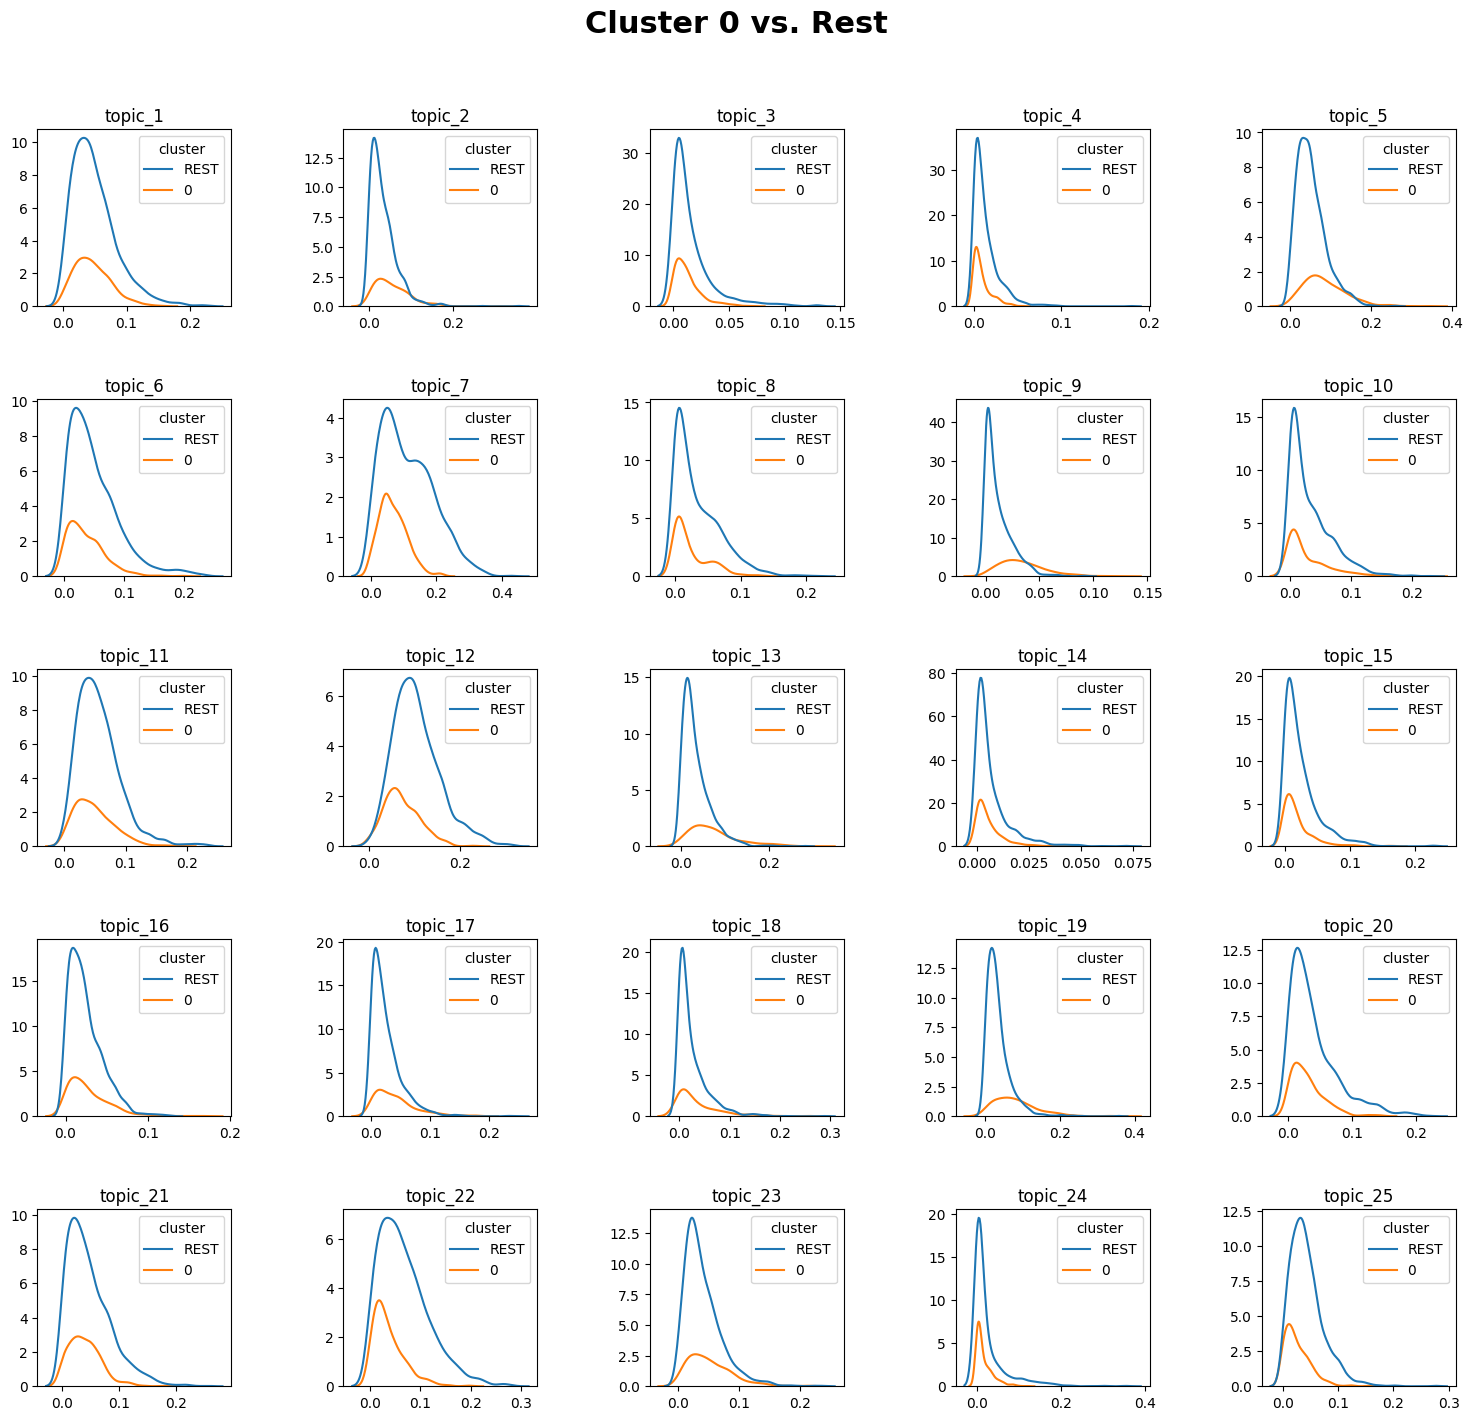

In [244]:
one_vs_rest_kde(daily_avg_by_topic.copy(), cluster_col='cluster', cluster_val=0, viz_cols=5, title='Cluster 0 vs. Rest')

In [245]:
one_vs_rest_table(daily_avg_by_topic, cluster_col='cluster', cluster_val=0).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_19         0.046412        0.025067      0.081710   0.035298   
topic_7         -0.044595       -0.036364      0.068264   0.112859   
topic_13         0.038888        0.022757      0.072842   0.033954   
topic_5          0.033209        0.016446      0.084939   0.051730   
topic_12        -0.032313       -0.012739      0.071951   0.104263   
topic_22        -0.029821       -0.018240      0.036836   0.066658   
topic_9          0.022436        0.008541      0.033902   0.011466   
topic_2          0.021269        0.010368      0.055003   0.033734   
topic_25        -0.016873       -0.007265      0.026338   0.043211   
topic_17         0.014751        0.008999      0.039420   0.024670   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_19     0.057915  0.032848     0.000084     0.362906  0.000064  0.357606  
topic_7      0.041714  0.078078     0.000154     0.215777  0.000124  0.425293  
topic_13     0.054174  0.031418     0.000105     0.296993  0.000105  0.278319  
topic_5      0.052510  0.036063     0.000165     0.338768  0.000163  0.257566  
topic_12     0.038470  0.051209     0.000137     0.227629  0.000114  0.312999  
topic_22     0.031030  0.049270     0.000065     0.195736  0.000053  0.279489  
topic_9      0.021223  0.012682     0.000133     0.124359  0.000081  0.093432  
topic_2      0.041907  0.031539     0.000298     0.305580  0.000239  0.354852  
topic_25     0.023402  0.030667     0.000058     0.157874  0.000048  0.274850  
topic_17     0.034744  0.025745     0.000054     0.182318  0.000080  0.247987

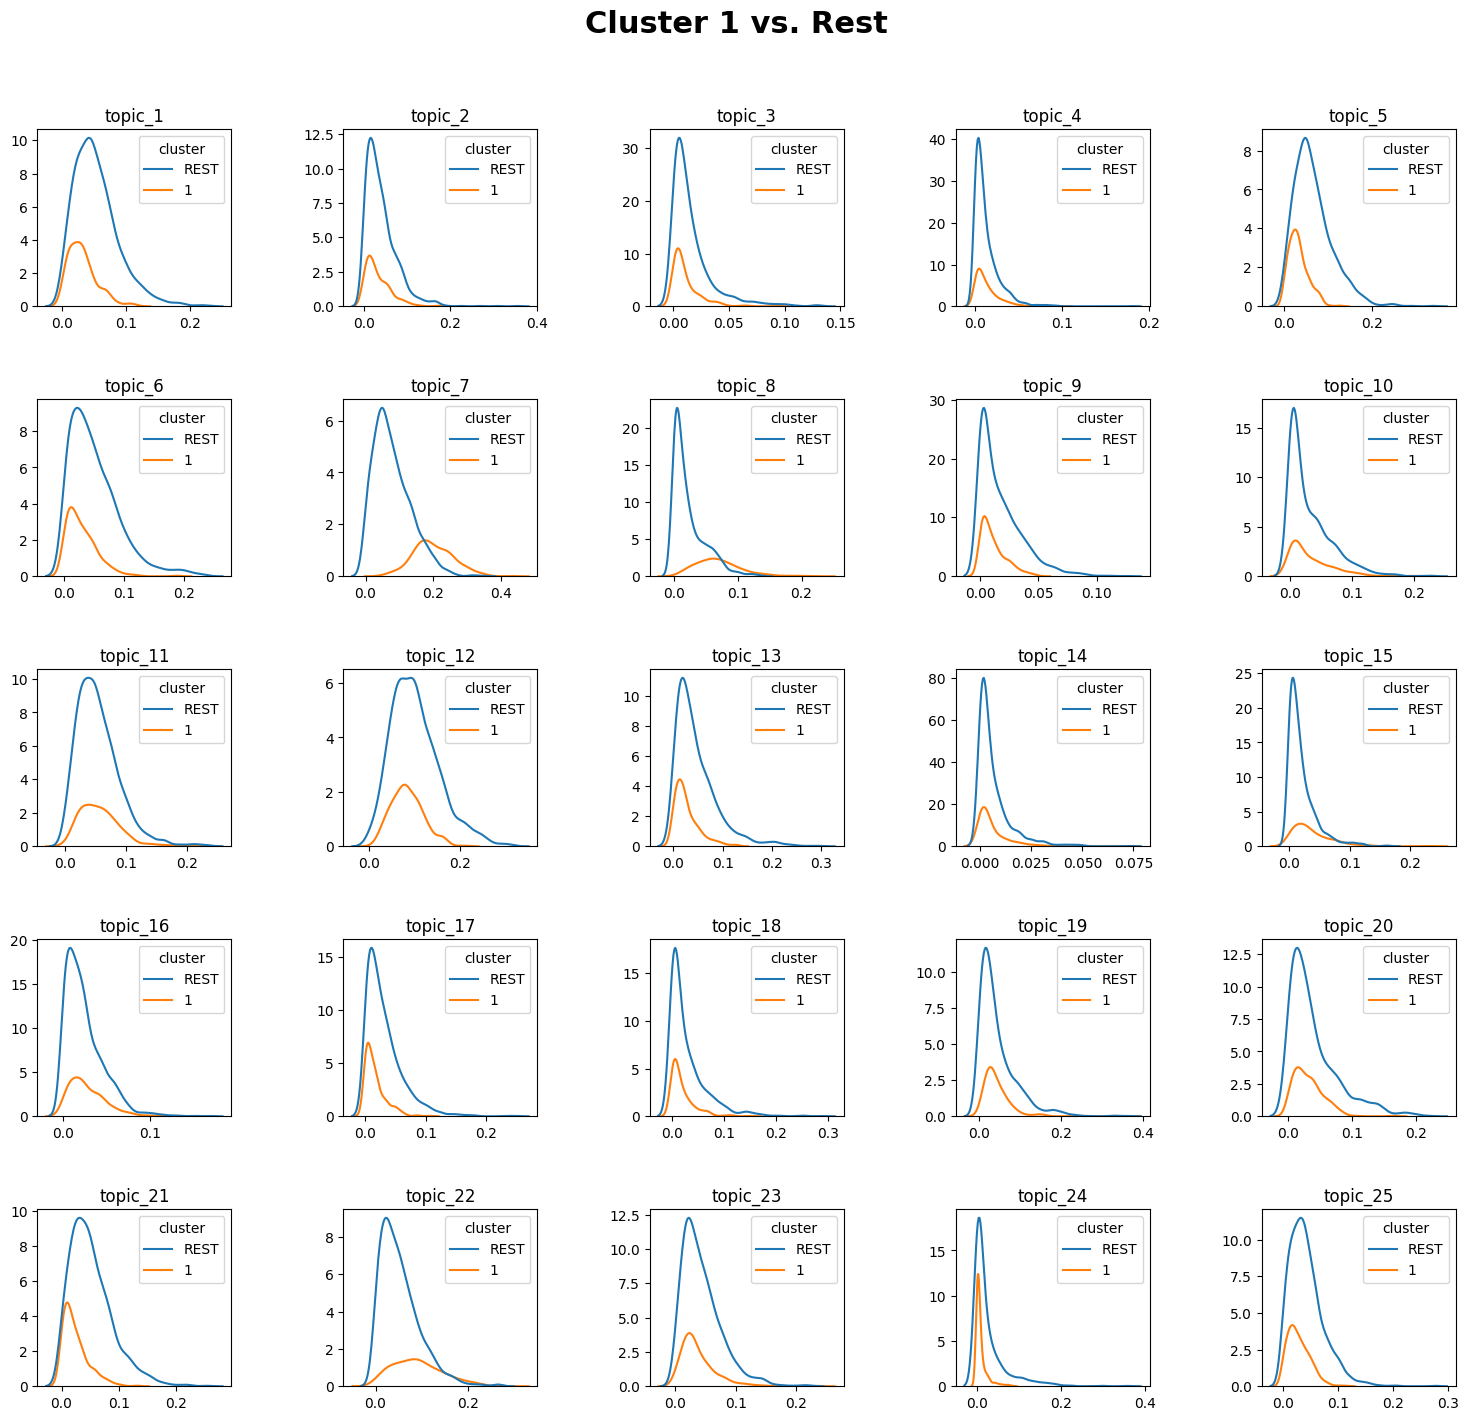

In [246]:
one_vs_rest_kde(daily_avg_by_topic.copy(), cluster_col='cluster', cluster_val=1, viz_cols=5, title='Cluster 1 vs. Rest')

In [247]:
one_vs_rest_table(daily_avg_by_topic, cluster_col='cluster', cluster_val=1).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_7          0.120935        0.004509      0.199586   0.078651   
topic_8          0.046461        0.010655      0.068957   0.022496   
topic_22         0.037654        0.010782      0.090239   0.052585   
topic_5         -0.033356       -0.021754      0.032299   0.065655   
topic_21        -0.027295       -0.015226      0.024450   0.051745   
topic_1         -0.021210       -0.012316      0.032112   0.053321   
topic_6         -0.021093       -0.016242      0.029807   0.050899   
topic_13        -0.019260       -0.017812      0.026967   0.046227   
topic_24        -0.017625       -0.028898      0.008377   0.026001   
topic_12        -0.017494       -0.018246      0.083394   0.100888   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_7      0.059446  0.054937     0.053527     0.425293  0.000124  0.343825  
topic_8      0.035848  0.025194     0.008798     0.218371  0.000083  0.135168  
topic_22     0.053475  0.042693     0.000087     0.279489  0.000053  0.267819  
topic_5      0.021934  0.043687     0.000203     0.125748  0.000163  0.338768  
topic_21     0.022265  0.037491     0.000060     0.131415  0.000040  0.253403  
topic_1      0.022306  0.034621     0.000383     0.116326  0.000377  0.225098  
topic_6      0.025507  0.041749     0.000213     0.187408  0.000114  0.233459  
topic_13     0.025158  0.042970     0.000119     0.128490  0.000105  0.296993  
topic_24     0.013508  0.042406     0.000045     0.081939  0.000036  0.359677  
topic_12     0.034963  0.053208     0.009808     0.207811  0.000114  0.312999

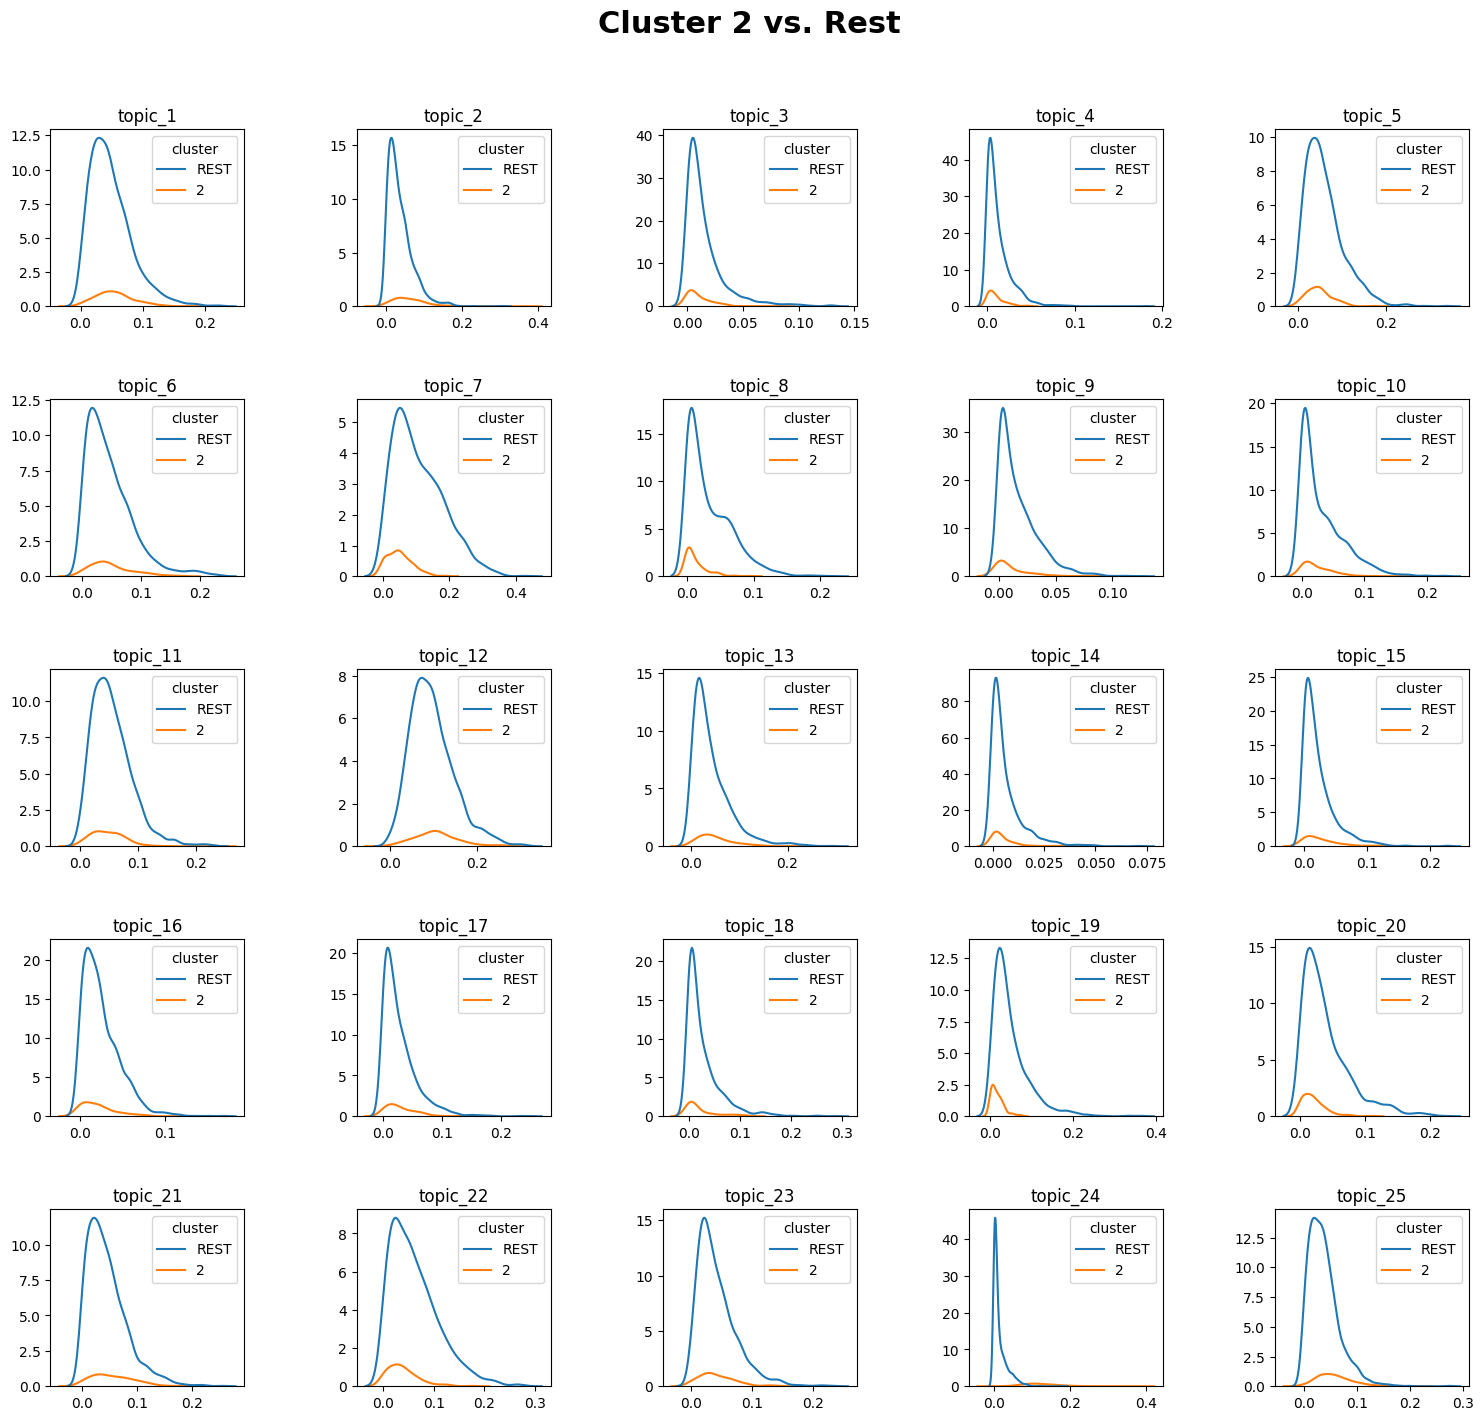

In [248]:
one_vs_rest_kde(daily_avg_by_topic.copy(), cluster_col='cluster', cluster_val=2, viz_cols=5, title='Cluster 2 vs. Rest')

In [249]:
one_vs_rest_table(daily_avg_by_topic, cluster_col='cluster', cluster_val=2).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_24         0.112931        0.036477      0.126059   0.013128   
topic_7         -0.057507       -0.037503      0.050503   0.108011   
topic_19        -0.031641       -0.029261      0.016224   0.047865   
topic_2          0.026294        0.016274      0.062433   0.036139   
topic_22        -0.023581       -0.017192      0.038612   0.062193   
topic_8         -0.020988       -0.017323      0.012696   0.033685   
topic_25         0.020131        0.004280      0.058063   0.037933   
topic_20        -0.018950       -0.018306      0.020188   0.039138   
topic_5         -0.011755       -0.014263      0.048072   0.059827   
topic_12         0.009881       -0.000336      0.106393   0.096513   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_24     0.054872  0.018396     0.017505     0.359677  0.000036  0.180329  
topic_7      0.037273  0.074776     0.000153     0.184274  0.000124  0.425293  
topic_19     0.015444  0.044705     0.000073     0.072557  0.000064  0.362906  
topic_2      0.049036  0.032762     0.000543     0.354852  0.000239  0.305580  
topic_22     0.031112  0.048304     0.000065     0.174661  0.000053  0.279489  
topic_8      0.016676  0.033999     0.000139     0.093605  0.000083  0.218371  
topic_25     0.033466  0.029186     0.000067     0.206935  0.000048  0.274850  
topic_20     0.018579  0.036885     0.000070     0.107151  0.000041  0.220369  
topic_5      0.029013  0.043276     0.000198     0.172691  0.000163  0.338768  
topic_12     0.050153  0.050489     0.000145     0.259431  0.000114  0.312999

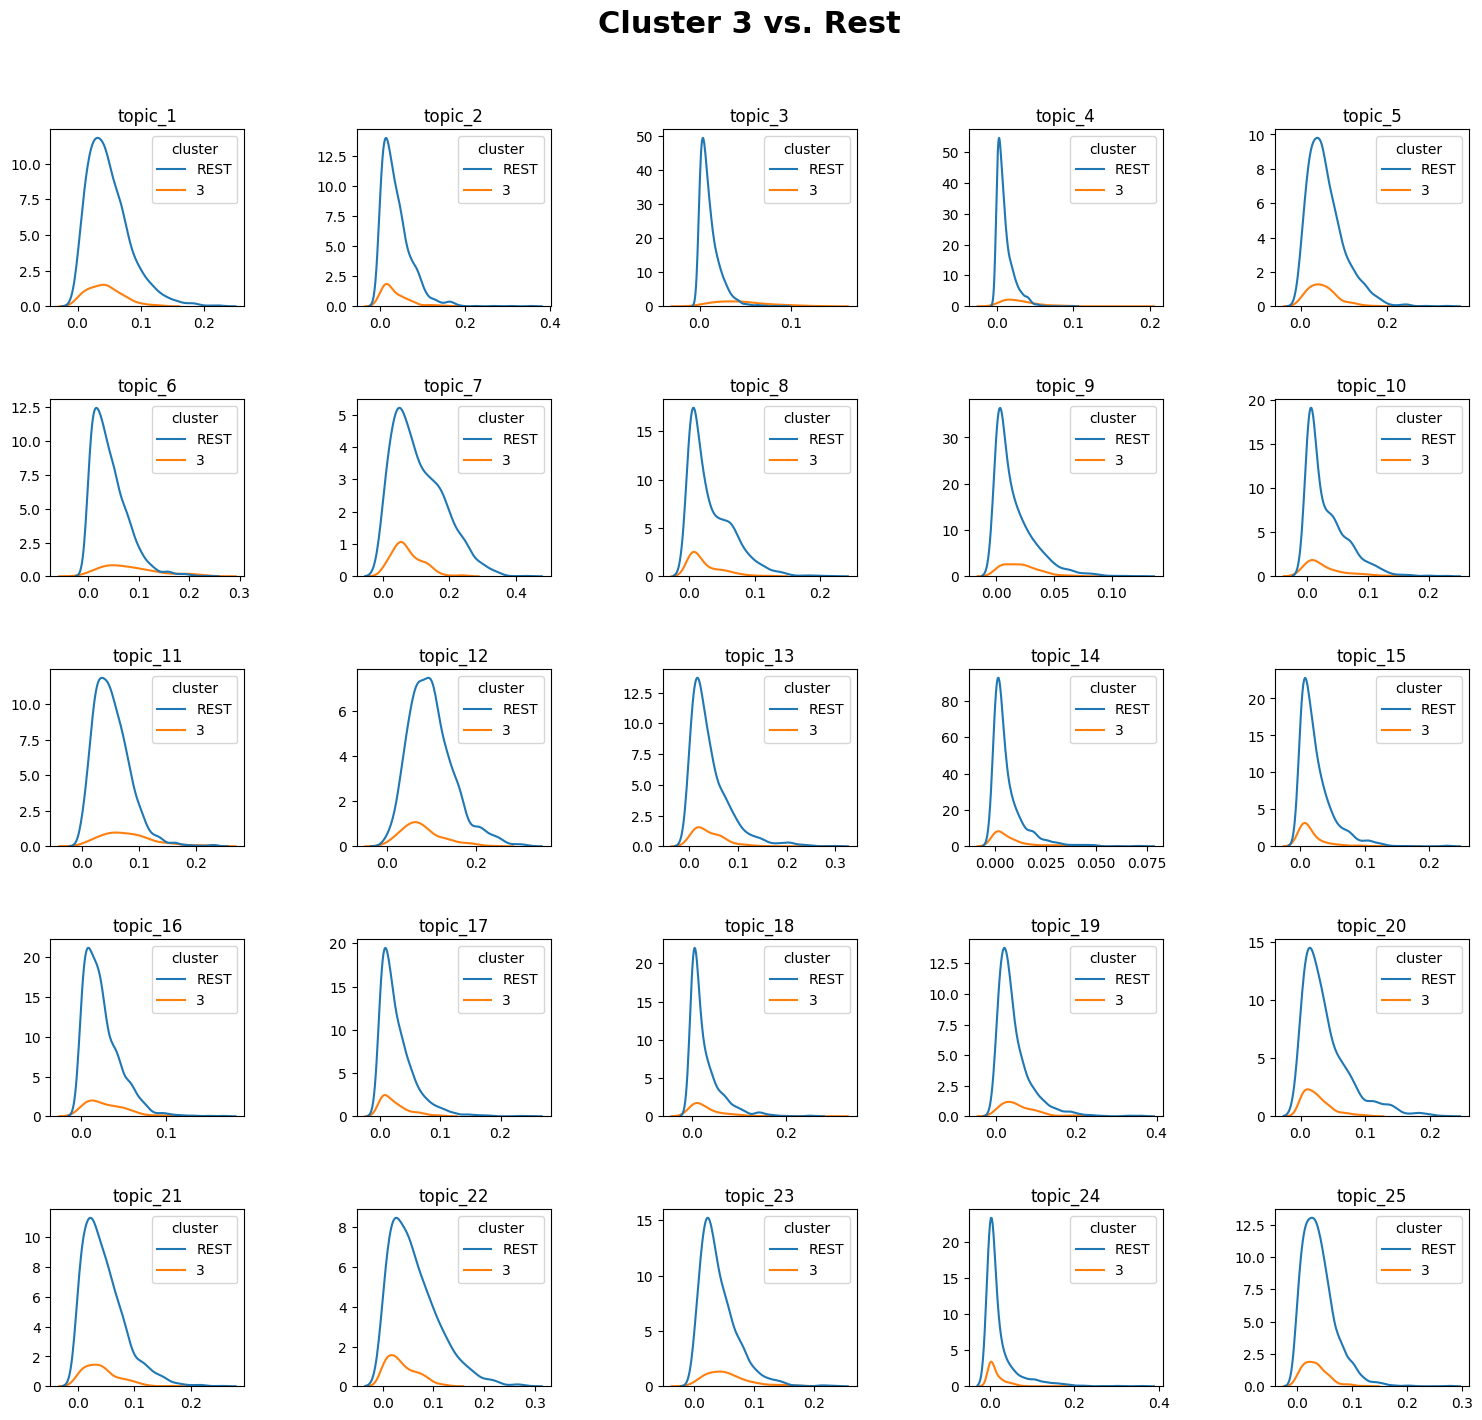

In [250]:
one_vs_rest_kde(daily_avg_by_topic.copy(), cluster_col='cluster', cluster_val=3, viz_cols=5, title='Cluster 3 vs. Rest')

In [251]:
one_vs_rest_table(daily_avg_by_topic, cluster_col='cluster', cluster_val=3).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_6          0.040573        0.021042      0.082746   0.042173   
topic_3          0.034633        0.018005      0.045766   0.011133   
topic_7         -0.034282       -0.030747      0.072745   0.107027   
topic_11         0.026718        0.013341      0.078374   0.051655   
topic_22        -0.025944       -0.019124      0.037143   0.063088   
topic_12        -0.020723       -0.004904      0.078865   0.099588   
topic_4          0.019626        0.013133      0.029908   0.010281   
topic_20        -0.014300       -0.015395      0.024842   0.039141   
topic_23         0.012566        0.004687      0.053609   0.041043   
topic_19         0.010274        0.000019      0.054415   0.044142   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_6      0.056035  0.034993     0.001632     0.232513  0.000114  0.233459  
topic_3      0.029174  0.011170     0.000343     0.131429  0.000209  0.091687  
topic_7      0.045342  0.076089     0.000247     0.239924  0.000124  0.425293  
topic_11     0.045120  0.031779     0.007377     0.220740  0.000080  0.232770  
topic_22     0.029460  0.048584     0.000055     0.127597  0.000053  0.279489  
topic_12     0.045725  0.050629     0.000114     0.235153  0.000120  0.312999  
topic_4      0.024091  0.010958     0.000268     0.180017  0.000183  0.098535  
topic_20     0.021801  0.037196     0.000060     0.104800  0.000041  0.220369  
topic_23     0.036068  0.031380     0.000052     0.194621  0.000037  0.235381  
topic_19     0.043836  0.043817     0.000105     0.231309  0.000064  0.362906

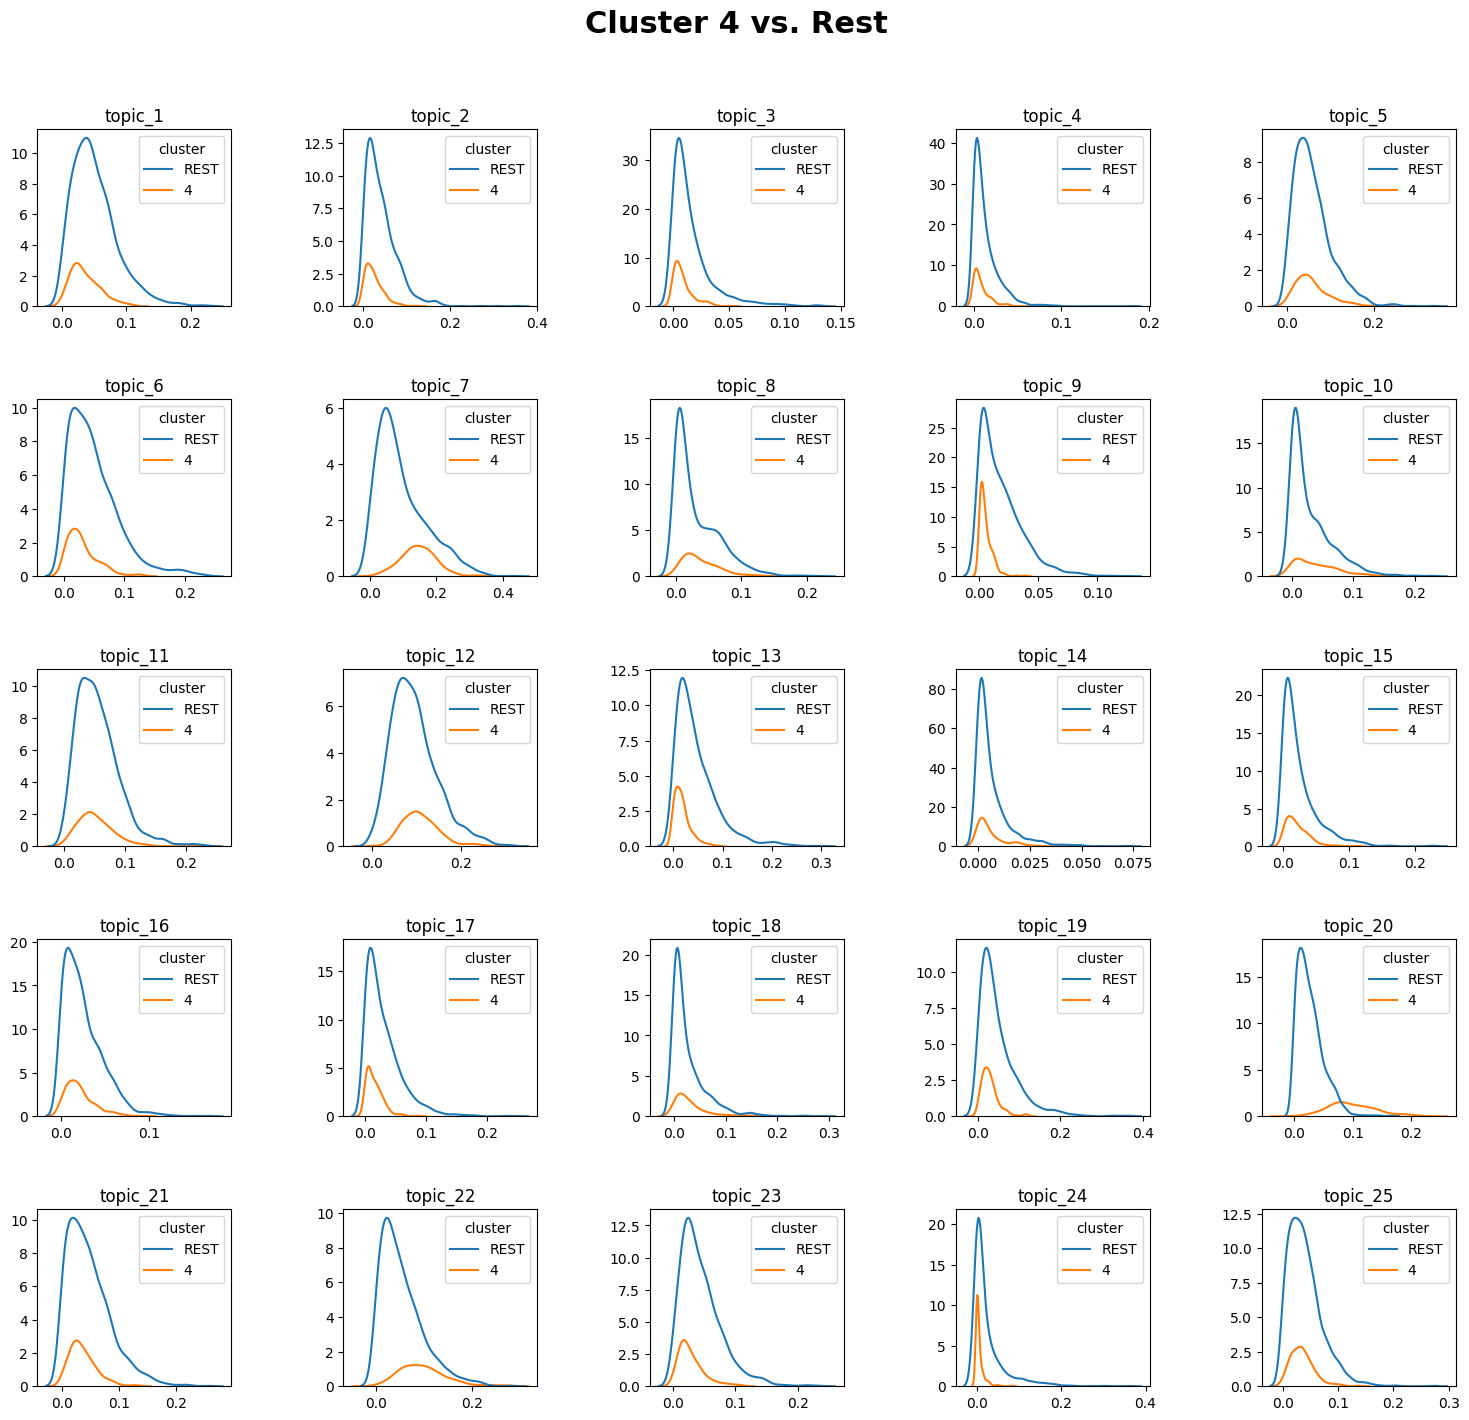

In [252]:
one_vs_rest_kde(daily_avg_by_topic.copy(), cluster_col='cluster', cluster_val=4, viz_cols=5, title='Cluster 4 vs. Rest')

In [253]:
one_vs_rest_table(daily_avg_by_topic, cluster_col='cluster', cluster_val=4).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_20         0.071546        0.017946      0.098591   0.027046   
topic_7          0.051024       -0.021433      0.146794   0.095770   
topic_22         0.043436        0.004565      0.097295   0.053859   
topic_13        -0.028064       -0.025740      0.018372   0.046436   
topic_24        -0.019187       -0.030867      0.006050   0.025237   
topic_19        -0.019102       -0.025364      0.028974   0.048076   
topic_6         -0.018363       -0.015830      0.030944   0.049307   
topic_2         -0.016211       -0.015483      0.024476   0.040688   
topic_23        -0.016076       -0.012423      0.028706   0.044782   
topic_12         0.015079       -0.007904      0.110183   0.095105   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_20     0.040229  0.022282     0.000080     0.220369  0.000041  0.163302  
topic_7      0.053220  0.074653     0.016118     0.343825  0.000124  0.425293  
topic_22     0.048883  0.044318     0.000116     0.267819  0.000053  0.279489  
topic_13     0.016483  0.042223     0.000123     0.087789  0.000105  0.296993  
topic_24     0.010469  0.041336     0.000066     0.084264  0.000036  0.359677  
topic_19     0.020832  0.046196     0.000083     0.118120  0.000064  0.362906  
topic_6      0.025472  0.041302     0.000192     0.127714  0.000114  0.233459  
topic_2      0.021014  0.036497     0.000384     0.123491  0.000239  0.354852  
topic_23     0.020748  0.033171     0.000071     0.108926  0.000037  0.235381  
topic_12     0.043429  0.051333     0.000120     0.306956  0.000114  0.312999

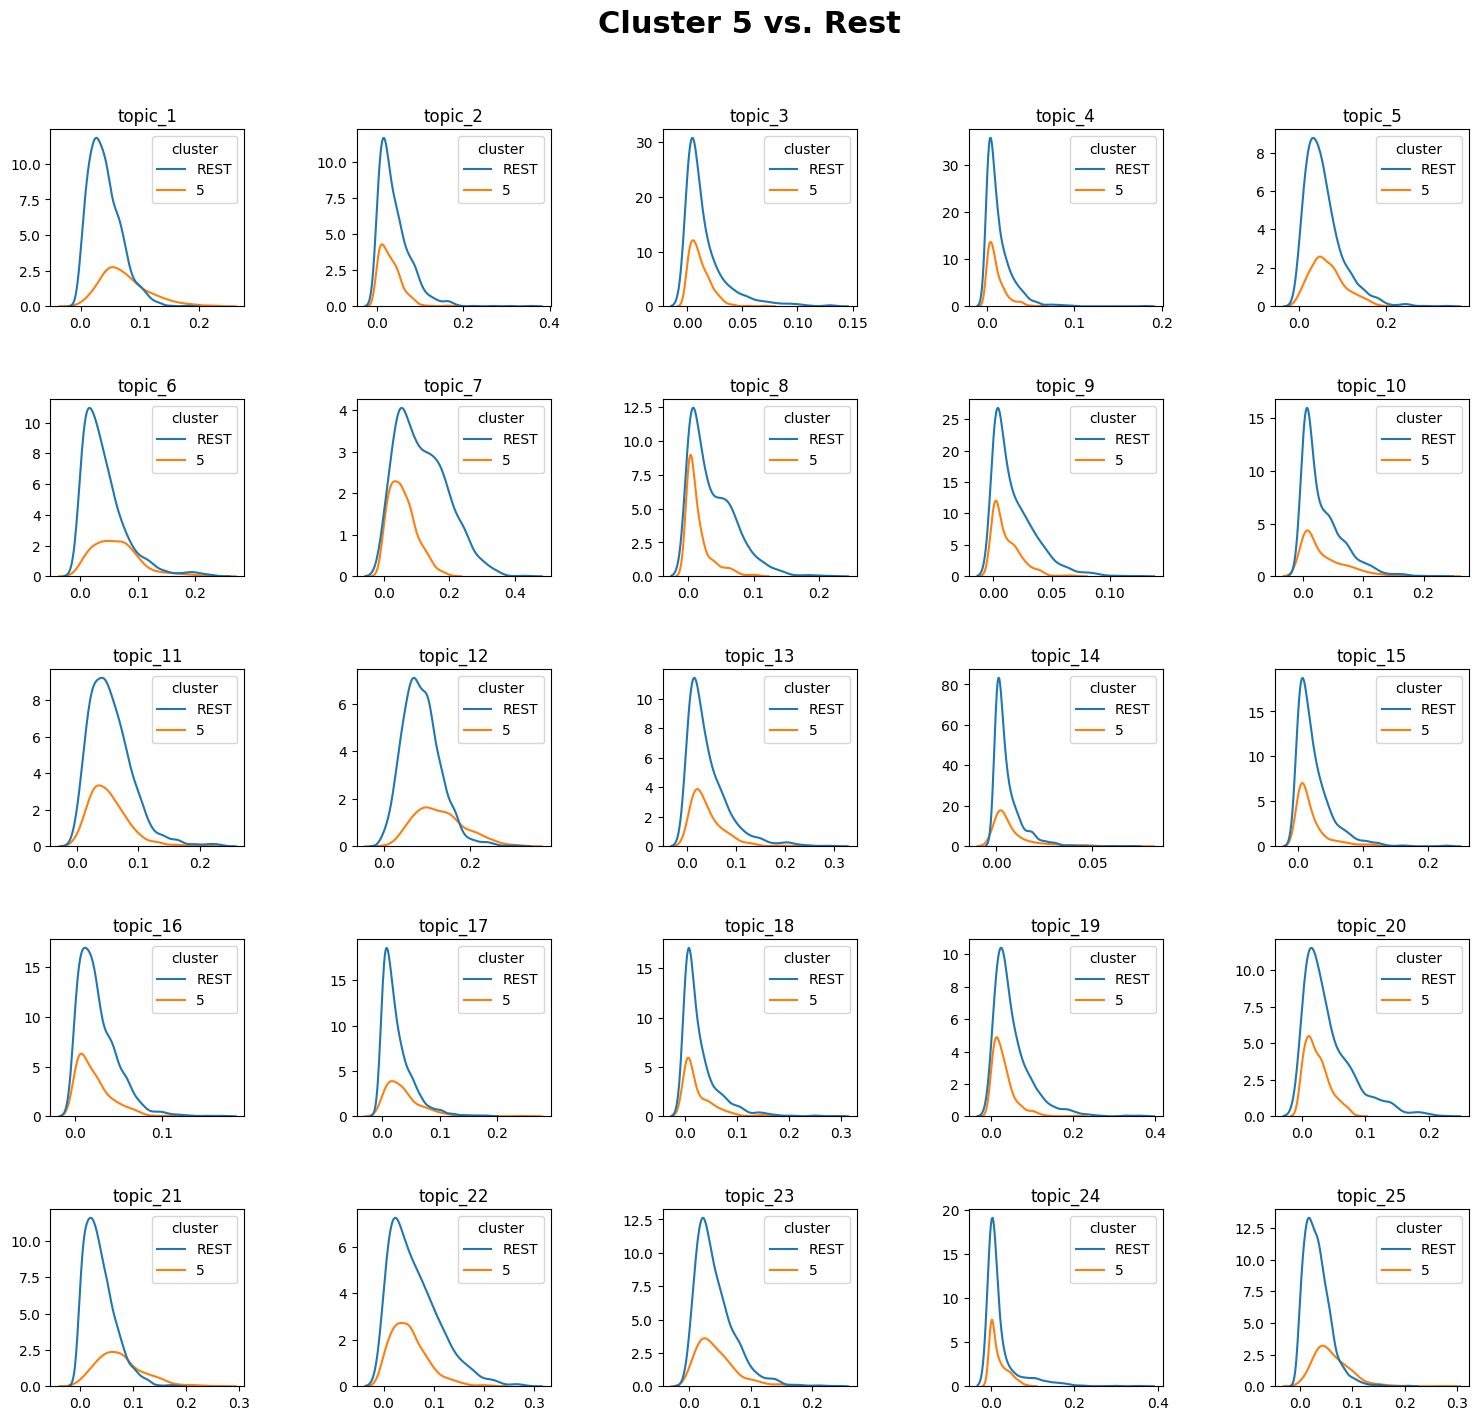

In [254]:
one_vs_rest_kde(daily_avg_by_topic.copy(), cluster_col='cluster', cluster_val=5, viz_cols=5, title='Cluster 5 vs. Rest')

In [255]:
one_vs_rest_table(daily_avg_by_topic, cluster_col='cluster', cluster_val=5).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_7         -0.058874       -0.035828      0.058712   0.117586   
topic_12         0.041665        0.013387      0.128867   0.087203   
topic_21         0.037801        0.014632      0.074803   0.037002   
topic_1          0.032598        0.012896      0.073679   0.041082   
topic_25         0.027321        0.009332      0.060271   0.032950   
topic_8         -0.022343       -0.015744      0.015044   0.037387   
topic_19        -0.021814       -0.019949      0.028749   0.050563   
topic_6          0.020625        0.002307      0.062217   0.041593   
topic_20        -0.017794       -0.020381      0.024109   0.041903   
topic_22        -0.012123       -0.013245      0.051077   0.063200   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_7      0.040864  0.076692     0.000124     0.198830  0.000153  0.425293  
topic_12     0.057056  0.043668     0.008648     0.312999  0.000114  0.306956  
topic_21     0.043317  0.028685     0.000040     0.253403  0.000057  0.179176  
topic_1      0.039815  0.026920     0.000377     0.225098  0.000383  0.179398  
topic_25     0.034470  0.025138     0.000089     0.274850  0.000048  0.206935  
topic_8      0.019381  0.035125     0.000083     0.105197  0.000119  0.218371  
topic_19     0.026958  0.046907     0.000064     0.208072  0.000073  0.362906  
topic_6      0.040655  0.038348     0.000188     0.233459  0.000114  0.232513  
topic_20     0.018770  0.039151     0.000041     0.085763  0.000047  0.220369  
topic_22     0.036920  0.050165     0.000053     0.211585  0.000055  0.279489

## Evaluate Date Cluster Sentiment

In [256]:
# Add cluster predictions to the articles dataframe
daily_avg_df['cluster'] = y_predicted

# Set the aggregations list
aggs = ['count', 'mean', 'std', 'min', 'max']

In [257]:
daily_avg_df.groupby('cluster').agg({'num_words': aggs,
                                     'bitcoin_body_perc': aggs}).reset_index().sort_values(('num_words', 'mean'), ascending=False)

cluster num_words                                                   \
              count        mean         std         min          max   
1       1       332  670.599152  158.184174  371.285714  1561.428571   
0       0       350  635.445465  161.111241  364.400000  1461.500000   
5       5       396  619.288386  152.856102  363.000000  1561.181818   
3       3       178  618.060480  139.707421  339.000000  1100.333333   
2       2       134  607.661592  121.387299  309.333333  1003.875000   
4       4       240  586.186496  119.516165  342.235294  1142.666667   

  bitcoin_body_perc                                          
              count      mean       std       min       max  
1               332  0.024880  0.004349  0.010643  0.046498  
0               350  0.020476  0.004649  0.010185  0.037885  
5               396  0.023696  0.004960  0.011178  0.041531  
3               178  0.020615  0.004078  0.008997  0.030623  
2               134  0.026890  0.004471  0.016954  0.043388  
4               240  0.026807  0.004148  0.015441  0.043614

In [258]:
daily_avg_df.groupby('cluster').agg({'polarity': aggs,
                                     'subjectivity': aggs}).reset_index().sort_values(('polarity', 'mean'), ascending=False)

cluster polarity                                         subjectivity  \
             count      mean       std       min       max        count   
0       0      350  0.093316  0.023822  0.027097  0.195214          350   
5       5      396  0.092549  0.021168  0.030617  0.184516          396   
2       2      134  0.090498  0.025200  0.012603  0.210177          134   
4       4      240  0.085222  0.019026  0.000171  0.148596          240   
1       1      332  0.079565  0.018696  0.007928  0.138335          332   
3       3      178  0.076542  0.021944  0.017046  0.136435          178   

                                           
       mean       std       min       max  
0  0.410303  0.028978  0.306581  0.486127  
5  0.414808  0.024847  0.351084  0.511199  
2  0.426459  0.025978  0.340034  0.514635  
4  0.410935  0.019534  0.359115  0.471577  
1  0.412610  0.019882  0.363369  0.471999  
3  0.403197  0.028234  0.286019  0.510601

## Dominant Topic by Date Sentiment Analysis

In [259]:
daily_avg_df['dominant_topic'] = daily_avg_df.loc[:, 'topic_1':'topic_25'].idxmax(axis=1)
daily_avg_df['dominant_share'] = daily_avg_df.loc[:, 'topic_1':'topic_25'].max(axis=1)

In [260]:
daily_avg_df.groupby('dominant_topic').agg({'polarity': aggs, 'subjectivity': aggs}).reset_index().sort_values(('polarity','count'), ascending=False)

dominant_topic polarity                                          \
                     count      mean       std       min       max   
20        topic_7      493  0.082656  0.019588  0.007928  0.147520   
3        topic_12      337  0.092588  0.020616  0.035971  0.155868   
18        topic_5      119  0.088215  0.020766  0.019247  0.178218   
13       topic_22       82  0.084043  0.021433  0.000171  0.135497   
9        topic_19       72  0.085142  0.025673  0.021529  0.140281   
4        topic_13       70  0.101074  0.025600  0.046770  0.195214   
19        topic_6       65  0.074211  0.020880  0.030617  0.136435   
2        topic_11       53  0.082774  0.023374  0.043227  0.133784   
15       topic_24       53  0.090527  0.020857  0.047938  0.162098   
12       topic_21       44  0.081412  0.015176  0.050574  0.124021   
0         topic_1       38  0.104402  0.025389  0.053911  0.151201   
8        topic_18       38  0.079715  0.022153  0.032044  0.121373   
10        topic_2       34  0.095255  0.028837  0.012603  0.210177   
14       topic_23       33  0.081238  0.028082  0.028170  0.165295   
11       topic_20       33  0.085821  0.018999  0.028479  0.114275   
1        topic_10       24  0.090461  0.029068  0.052192  0.184516   
16       topic_25       14  0.096868  0.016820  0.073334  0.118752   
7        topic_17       11  0.101479  0.024251  0.066389  0.151131   
5        topic_15        8  0.082879  0.023489  0.035906  0.107487   
21        topic_8        5  0.075030  0.018936  0.052061  0.104514   
6        topic_16        3  0.103196  0.008759  0.097622  0.113292   
17        topic_3        1  0.054166       NaN  0.054166  0.054166   

   subjectivity                                          
          count      mean       std       min       max  
20          493  0.411571  0.020819  0.350666  0.473101  
3           337  0.422892  0.022597  0.357335  0.514635  
18          119  0.398149  0.025234  0.286019  0.452168  
13           82  0.407349  0.020395  0.363369  0.451762  
9            72  0.403873  0.028649  0.306581  0.486127  
4            70  0.426030  0.027676  0.342651  0.485680  
19           65  0.396994  0.023864  0.326139  0.452432  
2            53  0.416227  0.029508  0.347792  0.510601  
15           53  0.421665  0.025988  0.340034  0.481699  
12           44  0.397401  0.018945  0.365825  0.436924  
0            38  0.416109  0.024269  0.351084  0.457622  
8            38  0.410045  0.029911  0.332154  0.476598  
10           34  0.421854  0.026936  0.386252  0.499239  
14           33  0.405211  0.028169  0.353262  0.465531  
11           33  0.405087  0.020778  0.364143  0.448785  
1            24  0.405949  0.034496  0.359648  0.511199  
16           14  0.413375  0.022886  0.365007  0.453536  
7            11  0.416559  0.031911  0.353955  0.455521  
5             8  0.419644  0.021364  0.380205  0.454446  
21            5  0.401495  0.038932  0.361107  0.447864  
6             3  0.428772  0.020700  0.405359  0.444644  
17            1  0.354792       NaN  0.354792  0.354792

# Clustering Articles By Topic Breakdown

#### *Create and Scale Cluster Data*

In [261]:
# Display all available columns
articles_df.columns

Index(['date', 'website', 'title', 'body', 'body_lower', 'title_lower',
       'tokenized', 'num_words', 'bitcoin_body_count', 'bitcoin_body_perc',
       'bitcoin_in_title', 'polarity', 'subjectivity', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8',
       'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14',
       'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20',
       'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25'],
      dtype='object')

In [262]:
cols = ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 
        'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10',
        'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15',
        'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20',
        'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25']

articles_by_topic = articles_df[cols]

In [263]:
# Standard scale the data
st_scale = StandardScaler()
articles_by_topic_st = st_scale.fit_transform(articles_by_topic)

#### *Determine Optimal PCA Components*

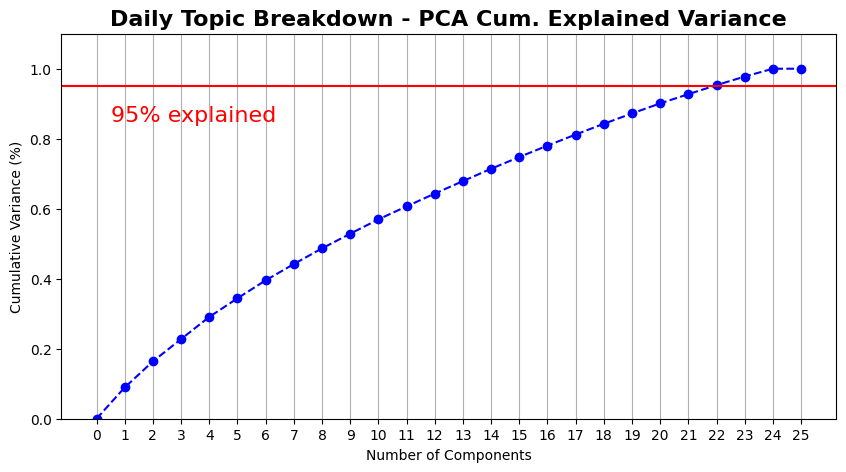

In [264]:
# Determine number of PCA components
pca_article_topics = PCA(len(cols)).fit(articles_by_topic_st) # include number of features for test

# Plot PCA components and cumulative explained variance
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(0, len(cols) + 1, step=1)
y = np.cumsum(np.insert(pca_article_topics.explained_variance_ratio_, 0, 0))

plt.ylim(0.0,1.1)
plt.plot(x, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(new_columns) + 1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Variance (%)')
plt.title('Daily Topic Breakdown - PCA Cum. Explained Variance', fontsize=16, fontweight='bold')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% explained', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [265]:
# Display variance explained in a dataframe
pd.DataFrame({'Components' : x, 'Cum. Variance' : y}).sort_values('Components', ascending=False)\
    .style.format({'Cum. Variance' : '{:0.1%}'})

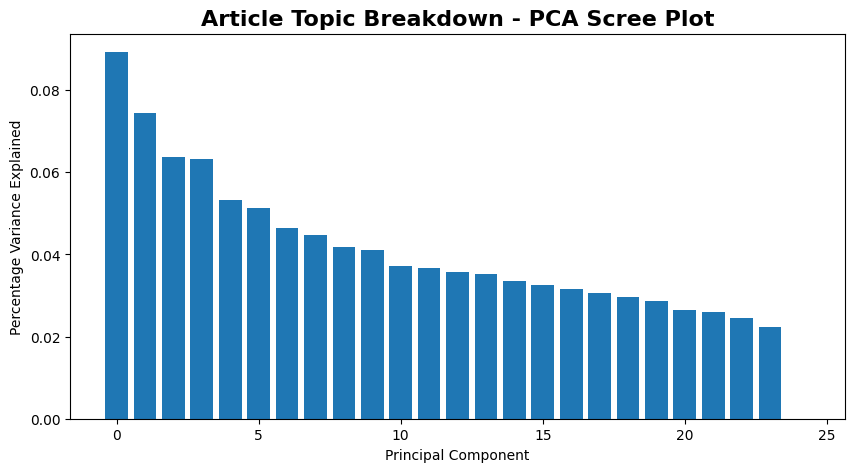

In [266]:
# Display Scree plot
fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(0, len(cols), step=1)
y = pca_article_topics.explained_variance_ratio_

plt.bar(x, y)
plt.title('Article Topic Breakdown - PCA Scree Plot', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Percentage Variance Explained')
plt.show()

In [267]:
# Display variance explained in a dataframe
pd.DataFrame({'Components' : x, 'Variance Explained' : y}).sort_values('Components')\
    .style.format({'Variance Explained' : '{:0.1%}'})

#### *Run PCA and K-Means Clustering*

In [268]:
# Rebuild PCA witth chosen number of components
pca_article_topics = PCA(22)

#Transform the clustering data
articles_by_topic_pca = pca_article_topics.fit_transform(articles_by_topic_st)

In [269]:
# Create K-Means model and make predictions
km = KMeans(n_clusters=6)
y_predicted = km.fit_predict(articles_by_topic_pca)

In [270]:
# Add predictions to the data and show mean for each cluster and feature combination
articles_by_topic['cluster'] = y_predicted
articles_by_topic.groupby('cluster').mean()

<ipython-input-270-b35b1b003f3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_by_topic['cluster'] = y_predicted


topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
cluster                                                                         
0        0.016715  0.006641  0.011309  0.002325  0.092431  0.007718  0.083397   
1        0.028574  0.009642  0.085945  0.074776  0.037619  0.238890  0.014701   
2        0.057218  0.018972  0.008504  0.004670  0.223660  0.039039  0.018731   
3        0.089050  0.018881  0.006096  0.005396  0.027185  0.038702  0.047010   
4        0.044425  0.168516  0.004786  0.009374  0.028285  0.004615  0.027749   
5        0.005235  0.006453  0.002770  0.002103  0.008211  0.004291  0.394146   

          topic_8   topic_9  topic_10  ...  topic_16  topic_17  topic_18  \
cluster                                ...                                 
0        0.003522  0.004913  0.006334  ...  0.009467  0.004919  0.212103   
1        0.002151  0.005817  0.021258  ...  0.058219  0.015203  0.010507   
2        0.002147  0.015169  0.146271  ...  0.009086  0.113339  0.010521   
3        0.004579  0.004639  0.013371  ...  0.015346  0.014857  0.007624   
4        0.003134  0.052284  0.025239  ...  0.061730  0.015809  0.003545   
5        0.142011  0.008777  0.006878  ...  0.014103  0.001877  0.015290   

         topic_19  topic_20  topic_21  topic_22  topic_23  topic_24  topic_25  
cluster                                                                        
0        0.018292  0.244046  0.034164  0.060148  0.036901  0.001919  0.018080  
1        0.008845  0.014891  0.040346  0.015020  0.053847  0.005484  0.038322  
2        0.013591  0.025233  0.052277  0.026683  0.045571  0.004425  0.017691  
3        0.016217  0.035183  0.085809  0.131402  0.023409  0.006131  0.086288  
4        0.017209  0.008415  0.007771  0.014391  0.030245  0.111917  0.021959  
5        0.135480  0.021359  0.012893  0.058981  0.062629  0.003614  0.005537  

[6 rows x 25 columns]

#### *Visualize K-Means Clusters*

In [271]:
x = articles_by_topic_pca[:, 0]
y = articles_by_topic_pca[:, 1]
z = articles_by_topic_pca[:, 2]

colors = {0 : 'red',
          1 : 'green',
          2 : 'blue',
          3 : 'aqua',
          4 : 'purple',
          5 : 'orange'
         }

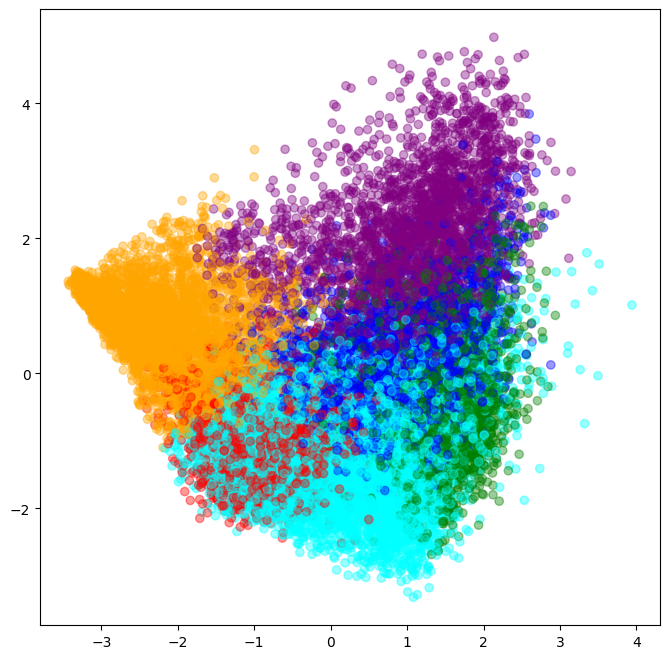

In [272]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(x, y, c=pd.Series(y_predicted).map(colors), alpha=0.4)
plt.show()

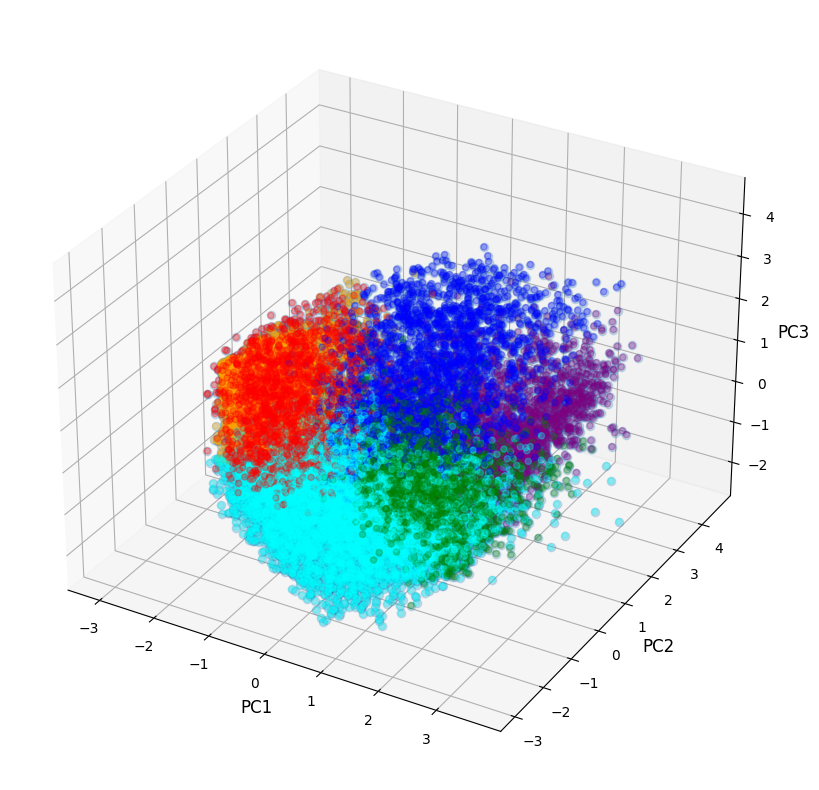

In [273]:
# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, linestyle='none', marker='o', alpha=0.2)
ax.scatter(x, y, z, c=pd.Series(y_predicted).map(colors), alpha=0.3)
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.axes.set_xlim3d(left=x.min(), right=x.max()) 
ax.axes.set_ylim3d(bottom=y.min(), top=y.max()) 
ax.axes.set_zlim3d(bottom=z.min(), top=z.max()) 
ax.view_init(elev=30)# azim=-30)

fig.tight_layout()

## One vs. Rest Plots - Articles by Topic

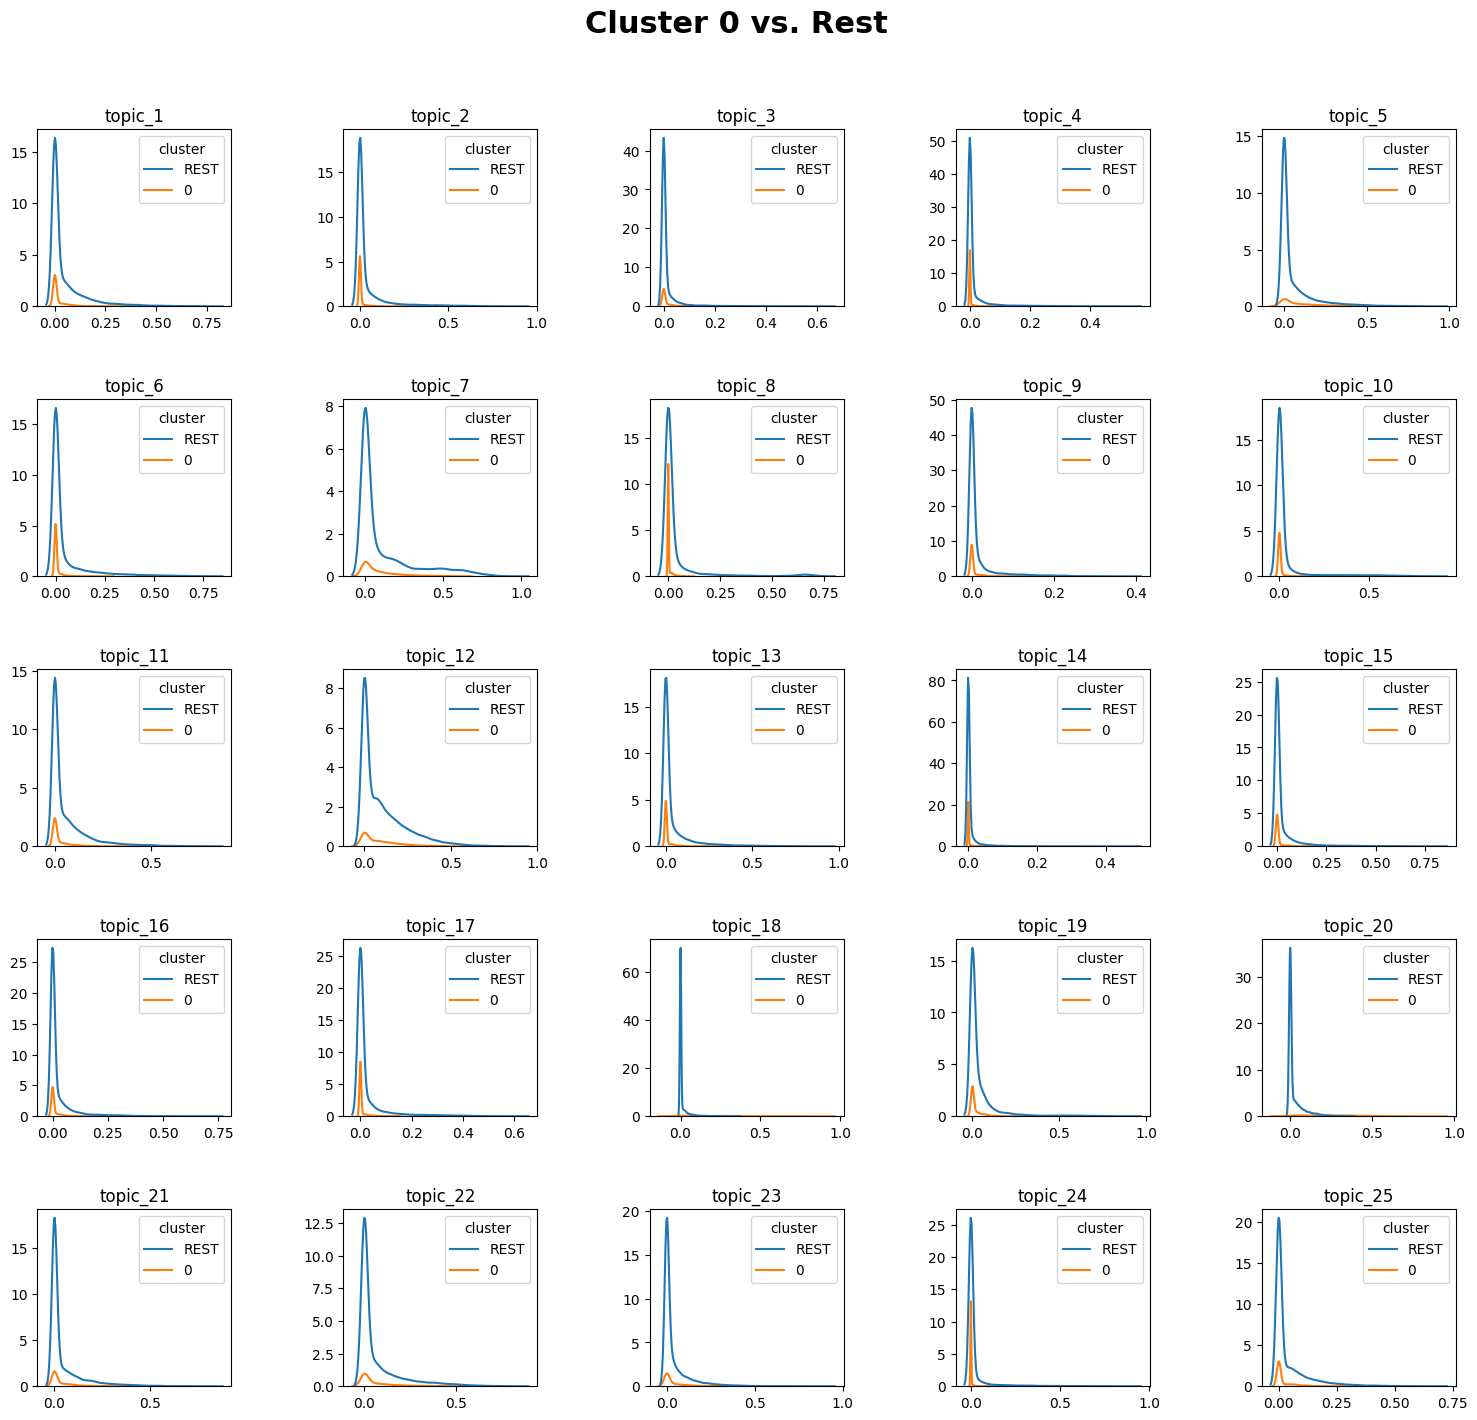

In [274]:
one_vs_rest_kde(articles_by_topic.copy(), cluster_col='cluster', cluster_val=0, viz_cols=5, title='Cluster 0 vs. Rest')

In [275]:
one_vs_rest_table(articles_by_topic, cluster_col='cluster', cluster_val=0).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_20         0.220210        0.126779      0.244046   0.023836   
topic_18         0.202608        0.173692      0.212103   0.009494   
topic_6         -0.039813       -0.085685      0.007718   0.047532   
topic_5          0.037252        0.007294      0.092431   0.055179   
topic_11        -0.036058       -0.057887      0.022215   0.058273   
topic_1         -0.034126       -0.059742      0.016715   0.050841   
topic_2         -0.032733       -0.075773      0.006641   0.039374   
topic_13        -0.032144       -0.073655      0.008734   0.040878   
topic_7         -0.032004       -0.075060      0.083397   0.115401   
topic_8         -0.031672       -0.099692      0.003522   0.035194   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_20     0.175466  0.048687     0.000023     0.836280  0.000006  0.371039  
topic_18     0.203608  0.029915     0.000027     0.825863  0.000007  0.361999  
topic_6      0.025668  0.111353     0.000050     0.279222  0.000010  0.799381  
topic_5      0.119498  0.112205     0.000048     0.633661  0.000016  0.937991  
topic_11     0.046253  0.104140     0.000033     0.417266  0.000007  0.823336  
topic_1      0.039249  0.098991     0.000086     0.391299  0.000053  0.785632  
topic_2      0.024379  0.100152     0.000072     0.323452  0.000017  0.912234  
topic_13     0.026787  0.100442     0.000029     0.323587  0.000008  0.934485  
topic_7      0.114775  0.189835     0.000051     0.605271  0.000013  0.964323  
topic_8      0.011223  0.110916     0.000036     0.117405  0.000009  0.755199

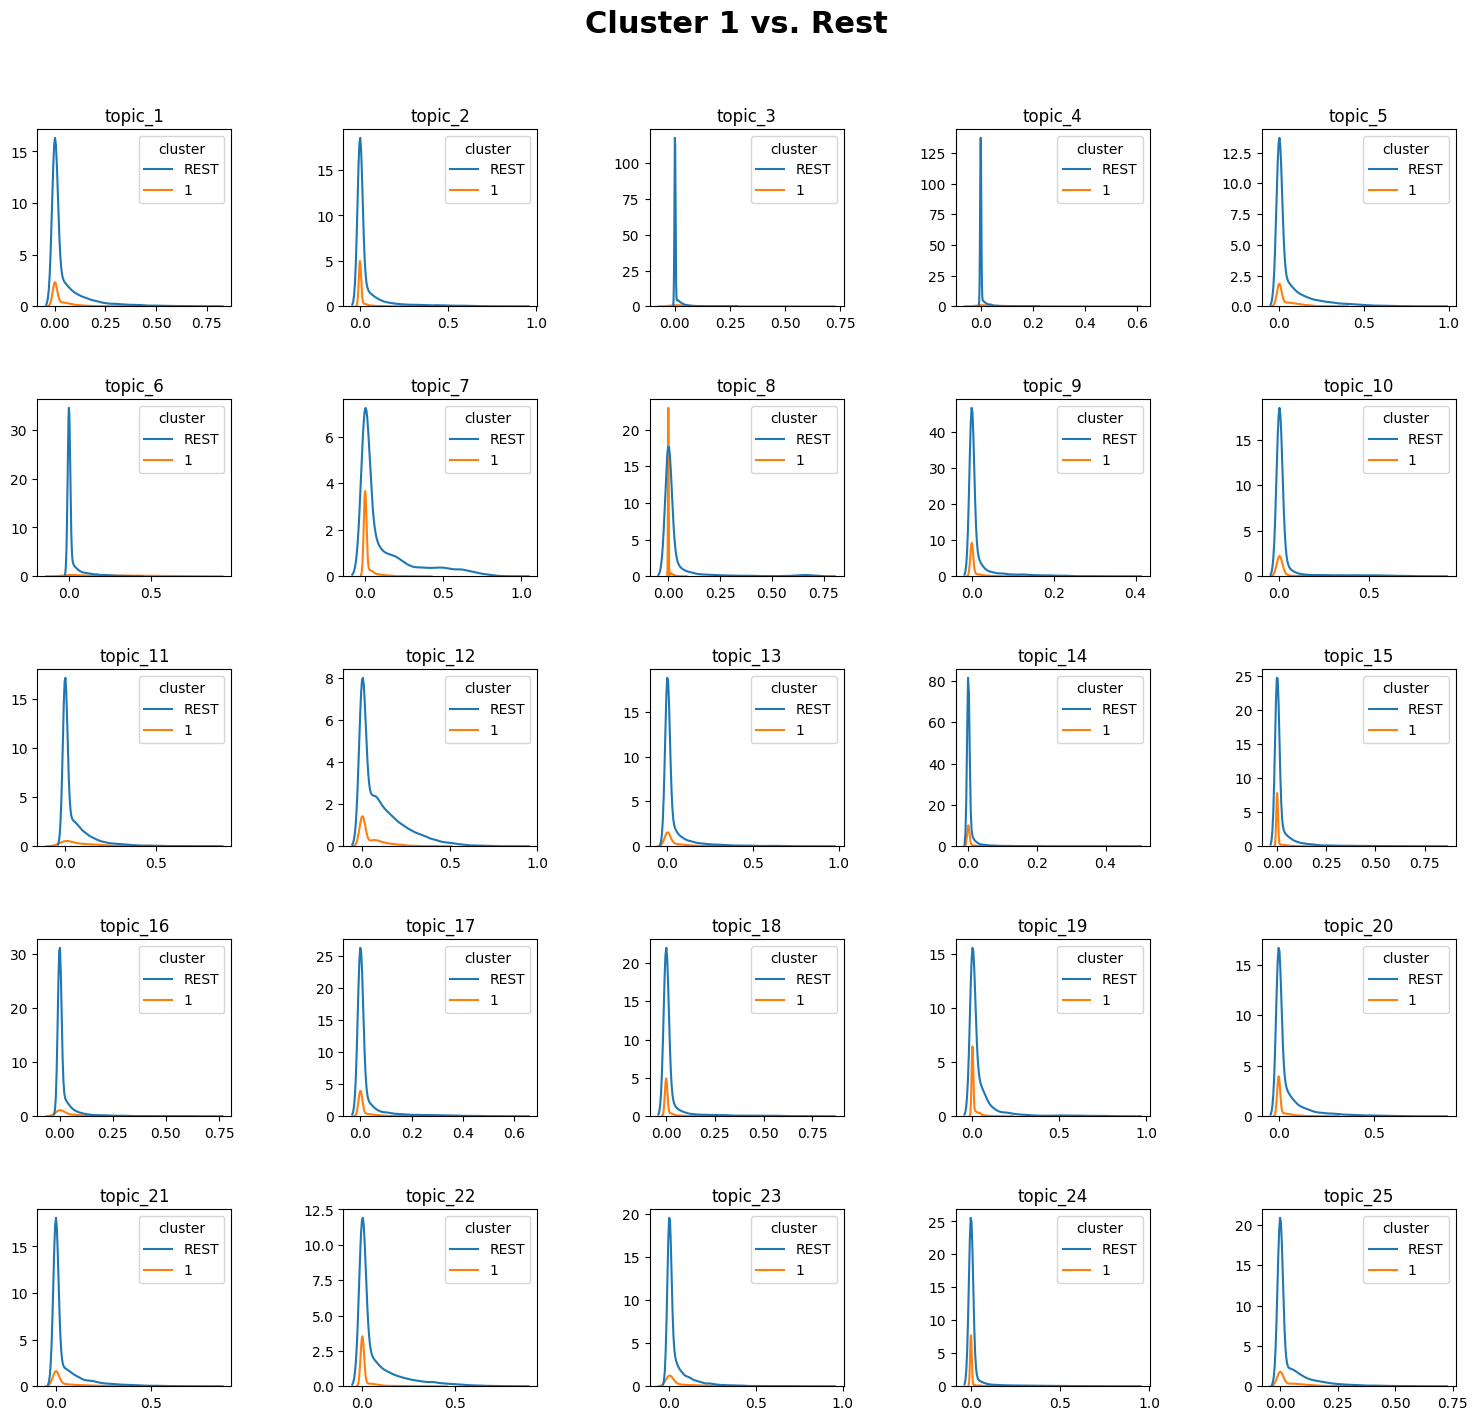

In [276]:
one_vs_rest_kde(articles_by_topic.copy(), cluster_col='cluster', cluster_val=1, viz_cols=5, title='Cluster 1 vs. Rest')

In [277]:
one_vs_rest_table(articles_by_topic, cluster_col='cluster', cluster_val=1).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_6          0.216811        0.154021      0.238890   0.022079   
topic_7         -0.108875       -0.151172      0.014701   0.123576   
topic_3          0.079939        0.095871      0.085945   0.006006   
topic_11         0.072603        0.066307      0.120340   0.047736   
topic_4          0.069907        0.078054      0.074776   0.004868   
topic_22        -0.056461       -0.083948      0.015020   0.071482   
topic_12        -0.055562       -0.058451      0.049366   0.104927   
topic_16         0.037089        0.035184      0.058219   0.021130   
topic_19        -0.035040       -0.084171      0.008845   0.043885   
topic_8         -0.033639       -0.104429      0.002151   0.035790   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_6      0.209578  0.055557     0.000063     0.799381  0.000010  0.427344  
topic_7      0.040011  0.191183     0.000038     0.398719  0.000013  0.964323  
topic_3      0.113179  0.017309     0.000066     0.649626  0.000030  0.273769  
topic_11     0.156044  0.089737     0.000030     0.745007  0.000007  0.823336  
topic_4      0.093621  0.015567     0.000080     0.553027  0.000019  0.220032  
topic_22     0.042040  0.125988     0.000016     0.424596  0.000008  0.839765  
topic_12     0.075599  0.134050     0.000026     0.460497  0.000020  0.892506  
topic_16     0.095382  0.060198     0.000033     0.577998  0.000005  0.740270  
topic_19     0.022350  0.106521     0.000018     0.218707  0.000005  0.922383  
topic_8      0.007179  0.111608     0.000035     0.083478  0.000009  0.755199

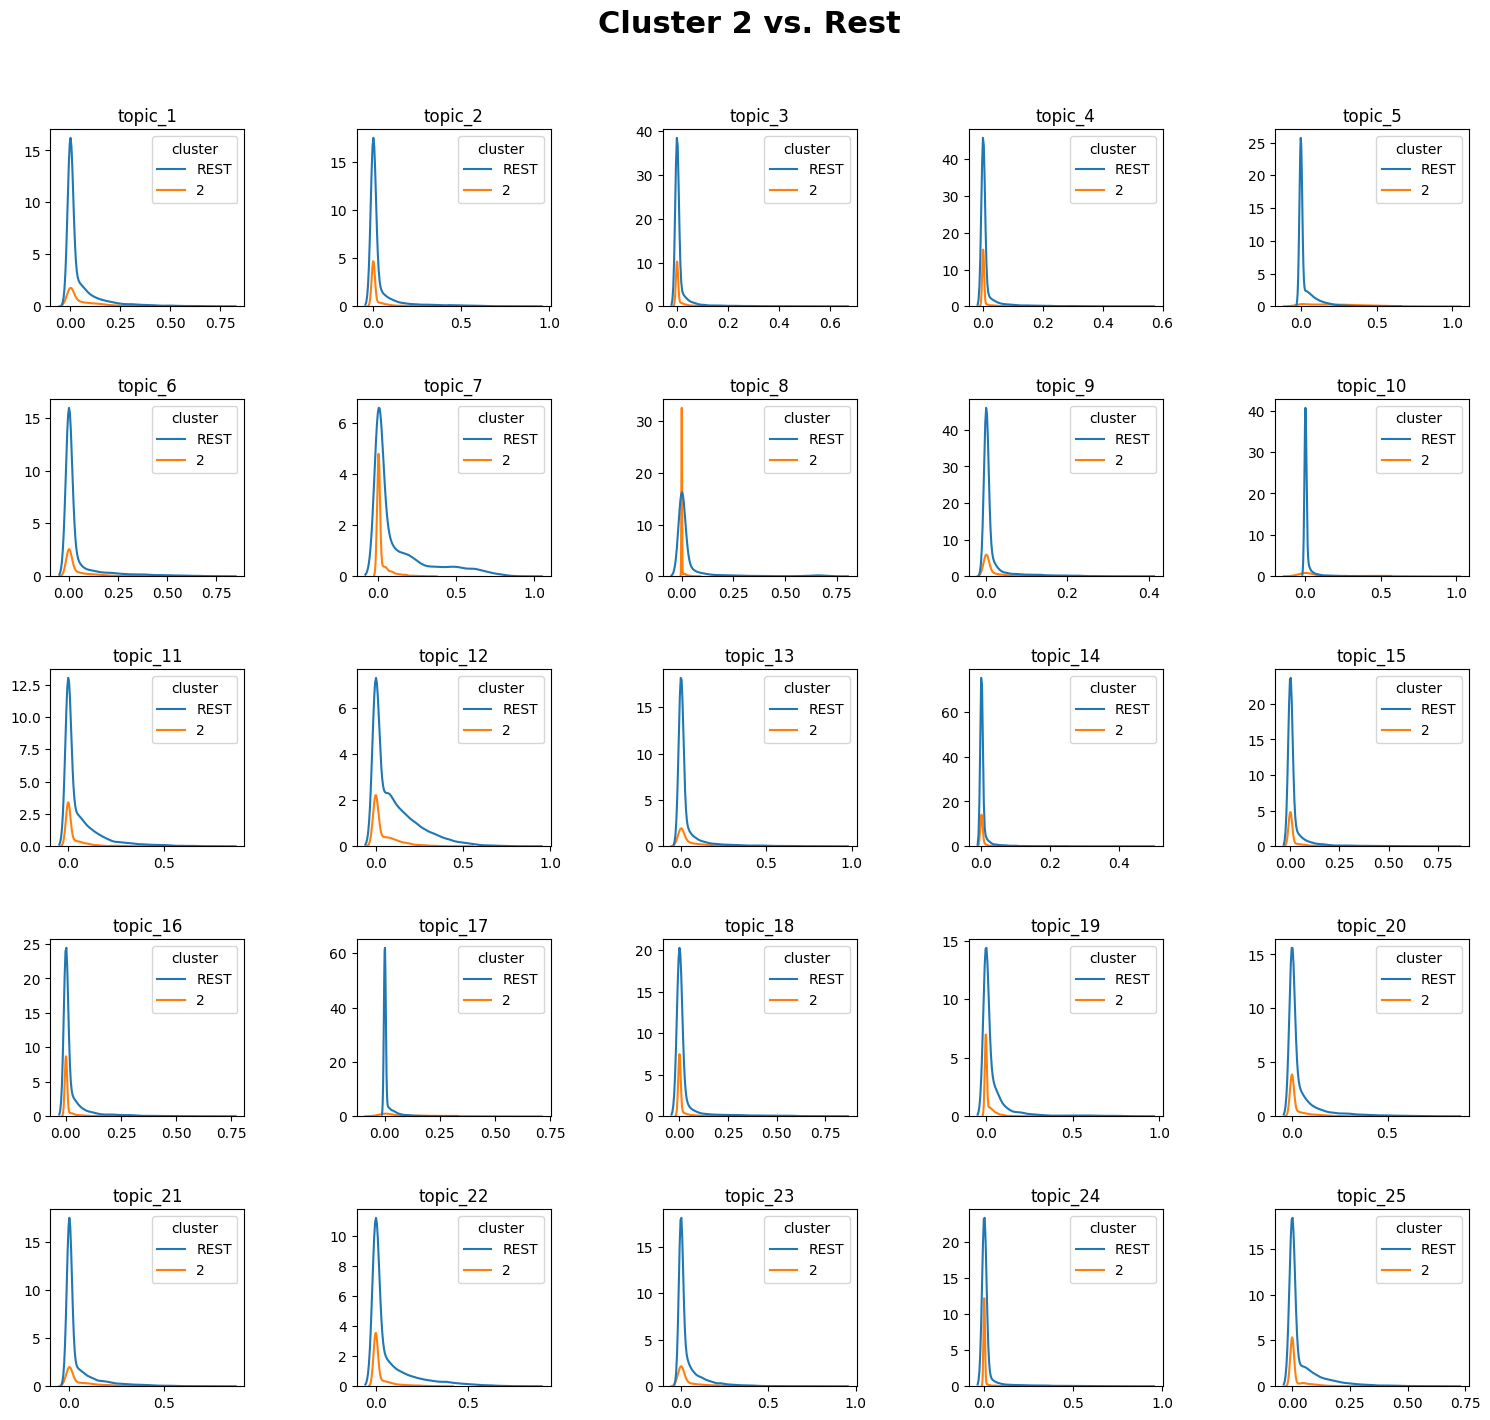

In [278]:
one_vs_rest_kde(articles_by_topic.copy(), cluster_col='cluster', cluster_val=2, viz_cols=5, title='Cluster 2 vs. Rest')

In [279]:
one_vs_rest_table(articles_by_topic, cluster_col='cluster', cluster_val=2).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_5          0.192931        0.117888      0.223660   0.030729   
topic_10         0.132225        0.185604      0.146271   0.014046   
topic_7         -0.109599       -0.149779      0.018731   0.128330   
topic_17         0.102472        0.112792      0.113339   0.010867   
topic_12        -0.061082       -0.059999      0.047012   0.108094   
topic_22        -0.045656       -0.070885      0.026683   0.072339   
topic_8         -0.035322       -0.106328      0.002147   0.037469   
topic_11        -0.032498       -0.047857      0.027255   0.059753   
topic_19        -0.031245       -0.080097      0.013591   0.044835   
topic_25        -0.025025       -0.043723      0.017691   0.042715   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_5      0.181907  0.064020     0.000042     0.937991  0.000016  0.633661  
topic_10     0.233032  0.047428     0.000021     0.882739  0.000018  0.547765  
topic_7      0.044543  0.194321     0.000034     0.345900  0.000013  0.964323  
topic_17     0.142797  0.030006     0.000014     0.624067  0.000012  0.318419  
topic_12     0.075548  0.135547     0.000031     0.508971  0.000020  0.892506  
topic_22     0.057043  0.127928     0.000015     0.381526  0.000008  0.839765  
topic_8      0.007752  0.114080     0.000032     0.085702  0.000009  0.755199  
topic_11     0.057854  0.105711     0.000019     0.494396  0.000007  0.823336  
topic_19     0.028641  0.108738     0.000017     0.283066  0.000005  0.922383  
topic_25     0.040437  0.084160     0.000013     0.361677  0.000011  0.690472

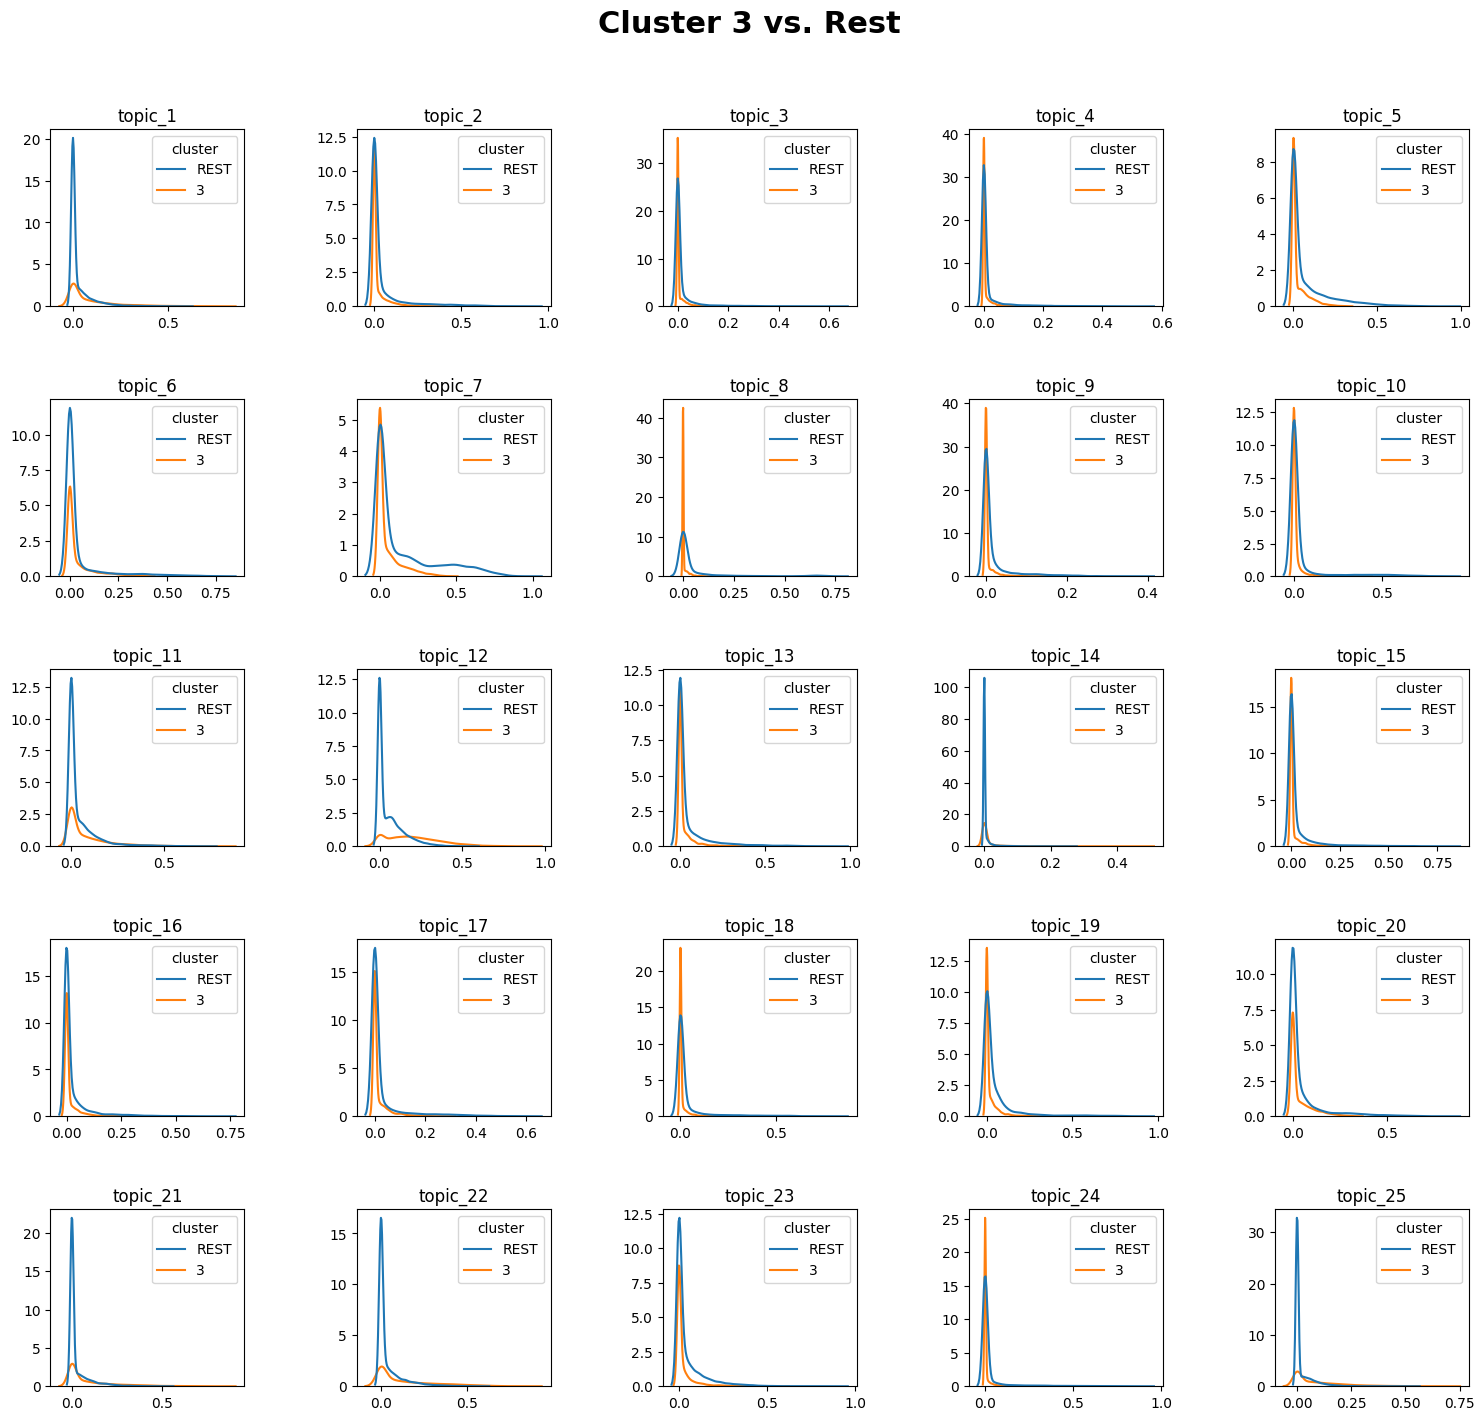

In [280]:
one_vs_rest_kde(articles_by_topic.copy(), cluster_col='cluster', cluster_val=3, viz_cols=5, title='Cluster 3 vs. Rest')

In [281]:
one_vs_rest_table(articles_by_topic, cluster_col='cluster', cluster_val=3).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_12         0.148805        0.082571      0.202102   0.053298   
topic_22         0.095006        0.095318      0.131402   0.036396   
topic_7         -0.094898       -0.128529      0.047010   0.141909   
topic_25         0.068286        0.074894      0.086288   0.018002   
topic_1          0.059688        0.070612      0.089050   0.029362   
topic_21         0.059069        0.070164      0.085809   0.026740   
topic_5         -0.045300       -0.079046      0.027185   0.072486   
topic_8         -0.040257       -0.111965      0.004579   0.044836   
topic_11         0.034982        0.031893      0.079244   0.044262   
topic_19        -0.034922       -0.081383      0.016217   0.051139   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_12     0.161085  0.078514     0.000032     0.892506  0.000020  0.562746  
topic_22     0.170098  0.074780     0.000008     0.839765  0.000010  0.592872  
topic_7      0.080454  0.208983     0.000013     0.465994  0.000024  0.964323  
topic_25     0.116410  0.041517     0.000012     0.690472  0.000011  0.547605  
topic_1      0.134431  0.063818     0.000074     0.785632  0.000053  0.602421  
topic_21     0.131187  0.061022     0.000004     0.834608  0.000010  0.533274  
topic_5      0.050649  0.129695     0.000016     0.325027  0.000028  0.937991  
topic_8      0.013655  0.125620     0.000009     0.210135  0.000021  0.755199  
topic_11     0.120524  0.088631     0.000007     0.823336  0.000017  0.745007  
topic_19     0.036982  0.118365     0.000005     0.301932  0.000011  0.922383

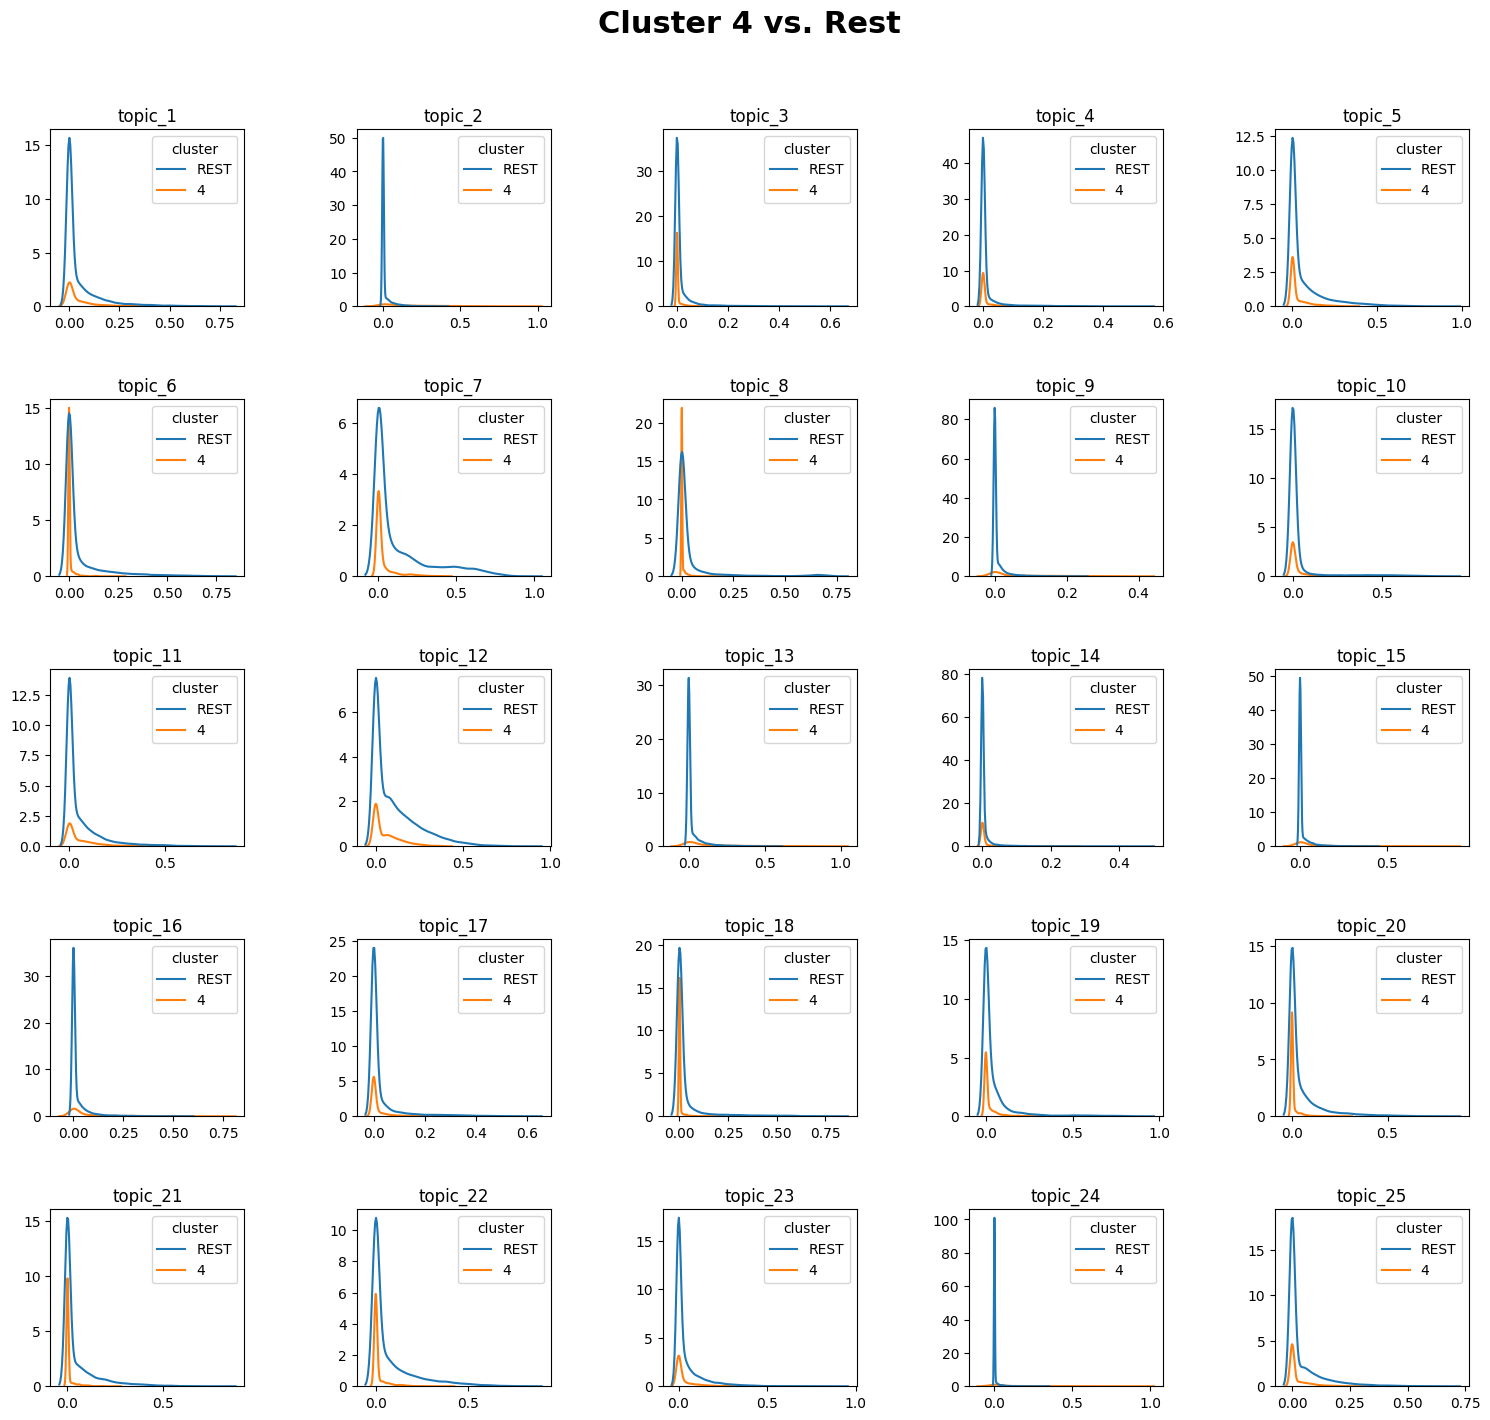

In [282]:
one_vs_rest_kde(articles_by_topic.copy(), cluster_col='cluster', cluster_val=4, viz_cols=5, title='Cluster 4 vs. Rest')

In [283]:
one_vs_rest_table(articles_by_topic, cluster_col='cluster', cluster_val=4).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_2          0.155038        0.147602      0.168516   0.013477   
topic_13         0.109231        0.125986      0.131059   0.021828   
topic_24         0.107207        0.154845      0.111917   0.004711   
topic_7         -0.099589       -0.129689      0.027749   0.127338   
topic_15         0.074500        0.114965      0.087620   0.013120   
topic_22        -0.060330       -0.088546      0.014391   0.074721   
topic_12        -0.047737       -0.058004      0.058652   0.106389   
topic_6         -0.046250       -0.097721      0.004615   0.050865   
topic_9          0.044683        0.055529      0.052284   0.007601   
topic_21        -0.043718       -0.073343      0.007771   0.051489   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_2      0.184815  0.037213     0.000087     0.912234  0.000017  0.407165  
topic_13     0.183658  0.057673     0.000017     0.934485  0.000008  0.588940  
topic_24     0.175841  0.020996     0.000009     0.916303  0.000006  0.342273  
topic_7      0.064809  0.194498     0.000024     0.431183  0.000013  0.964323  
topic_15     0.153446  0.038481     0.000013     0.829899  0.000012  0.438411  
topic_22     0.039853  0.128399     0.000010     0.399205  0.000008  0.839765  
topic_12     0.078263  0.136267     0.000020     0.389868  0.000025  0.892506  
topic_6      0.016828  0.114549     0.000025     0.276943  0.000010  0.799381  
topic_9      0.077192  0.021663     0.000019     0.395420  0.000011  0.248808  
topic_21     0.025385  0.098728     0.000010     0.263606  0.000004  0.834608

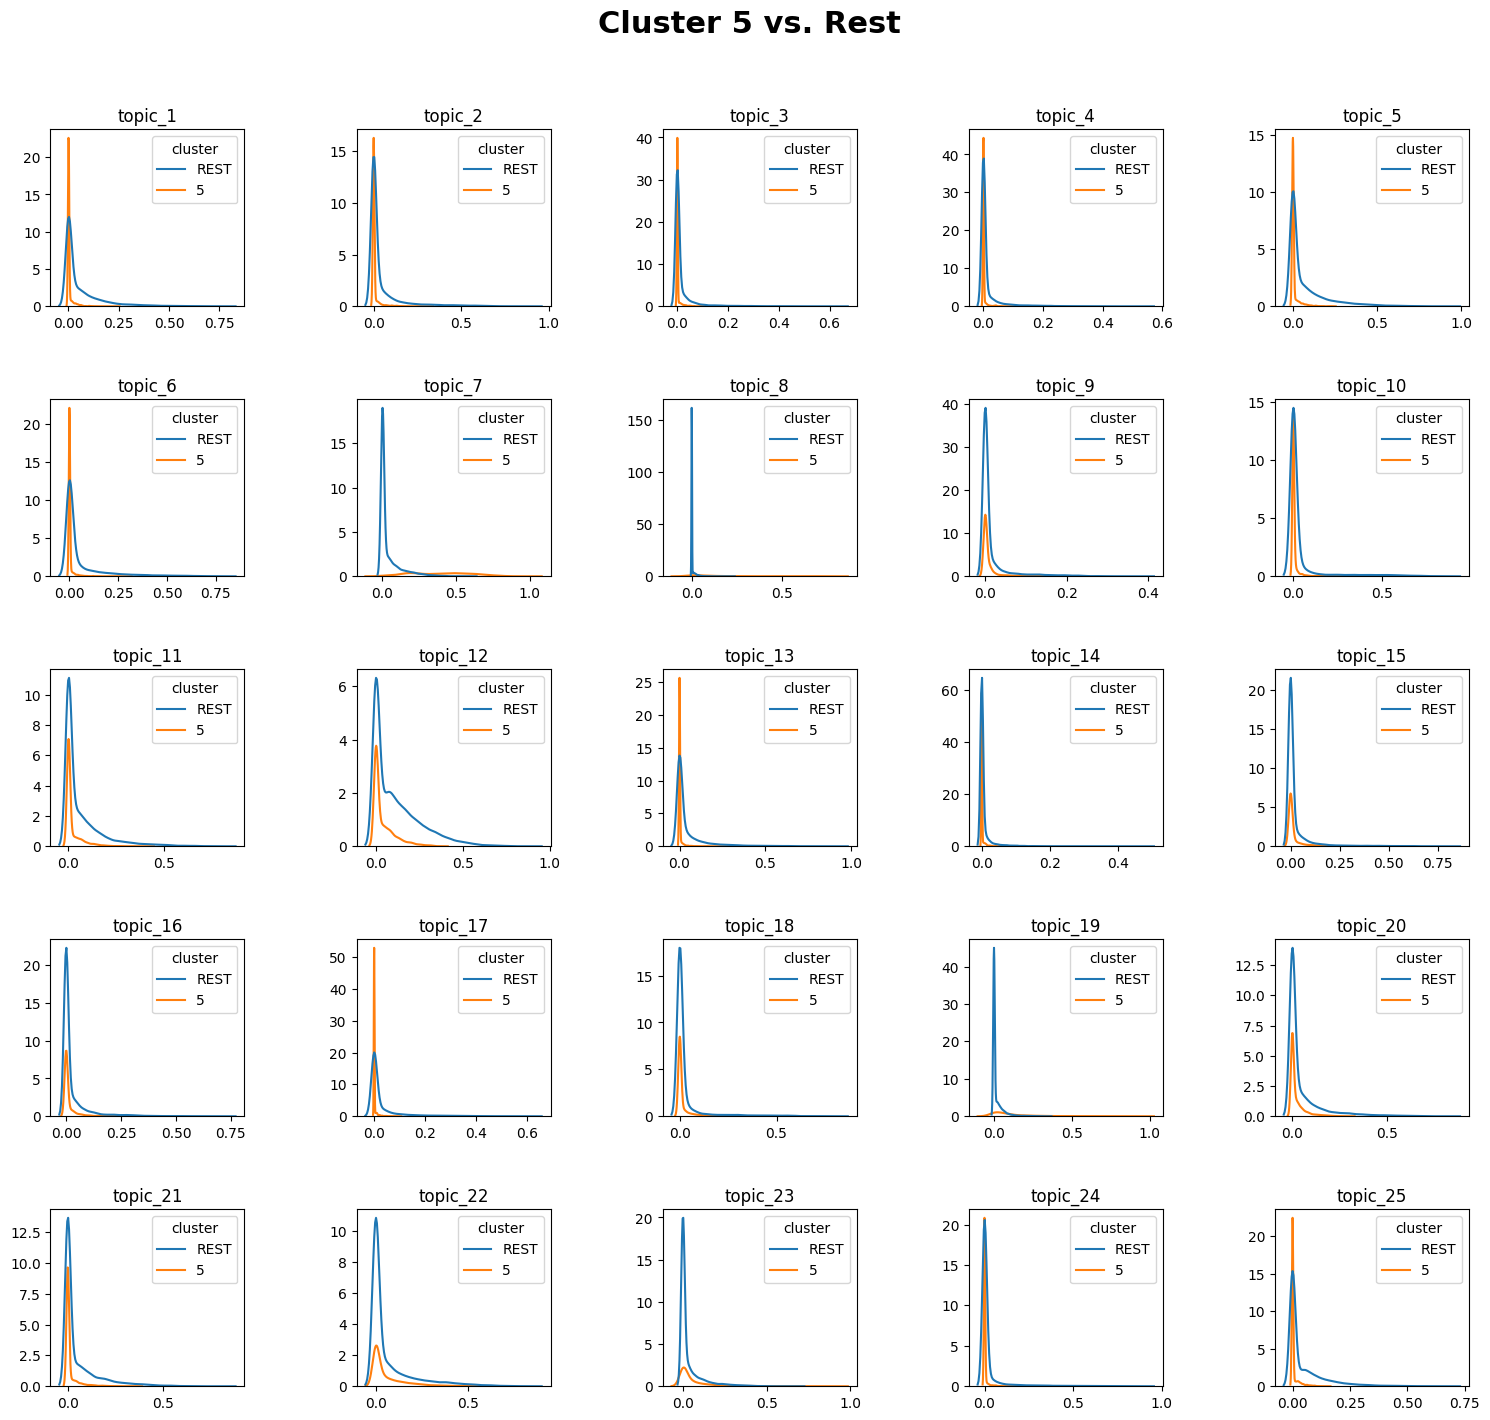

In [284]:
one_vs_rest_kde(articles_by_topic.copy(), cluster_col='cluster', cluster_val=5, viz_cols=5, title='Cluster 5 vs. Rest')

In [285]:
one_vs_rest_table(articles_by_topic, cluster_col='cluster', cluster_val=5).head(10)

Mean Difference  STD Difference  Cluster Mean  Rest Mean  \
topic_7          0.355944        0.126724      0.394146   0.038201   
topic_8          0.138574        0.184631      0.142011   0.003437   
topic_19         0.120264        0.148770      0.135480   0.015215   
topic_12        -0.071614       -0.073661      0.042656   0.114270   
topic_5         -0.063543       -0.098435      0.008211   0.071754   
topic_1         -0.053829       -0.088106      0.005235   0.059064   
topic_6         -0.050202       -0.100416      0.004291   0.054493   
topic_13        -0.043974       -0.091030      0.003243   0.047218   
topic_11        -0.043437       -0.064604      0.020716   0.064154   
topic_25        -0.042447       -0.070673      0.005537   0.047984   

          Cluster STD  Rest STD  Cluster Min  Cluster Max  Rest Min  Rest Max  
topic_7      0.202722  0.075998     0.000154     0.964323  0.000013  0.605271  
topic_8      0.196041  0.011411     0.000034     0.755199  0.000009  0.234568  
topic_19     0.183372  0.034602     0.000024     0.922383  0.000005  0.354183  
topic_12     0.065286  0.138947     0.000025     0.375708  0.000020  0.892506  
topic_5      0.025001  0.123436     0.000045     0.240101  0.000016  0.937991  
topic_1      0.016323  0.104429     0.000081     0.245084  0.000053  0.785632  
topic_6      0.017539  0.117955     0.000040     0.308534  0.000010  0.799381  
topic_13     0.015468  0.106499     0.000024     0.335658  0.000008  0.934485  
topic_11     0.044691  0.109296     0.000037     0.419524  0.000007  0.823336  
topic_25     0.016571  0.087244     0.000014     0.155737  0.000011  0.690472

## Evaluate Article Cluster Sentiment

In [286]:
# Add cluster predictions to the articles dataframe
articles_df['cluster'] = y_predicted

# Set the aggregations list
aggs = ['count', 'mean', 'std', 'min', 'max']

In [287]:
articles_df.groupby('cluster').agg({'num_words': aggs,
                                    'bitcoin_body_perc': aggs}).reset_index()

cluster num_words                                     bitcoin_body_perc  \
              count        mean         std  min    max             count   
0       0      1674  494.280167  280.250157  200   2806              1674   
1       1      1911  527.227630  316.382673  200   3000              1911   
2       2      2718  524.874172  328.027416  200   4127              2718   
3       3      5843  655.529180  503.233625  200  12007              5843   
4       4      2803  680.524438  467.648565  200   5161              2803   
5       5      3948  656.937943  402.362519  200   3159              3948   

                                           
       mean       std       min       max  
0  0.029134  0.013035  0.005208  0.086957  
1  0.019688  0.009927  0.005025  0.082102  
2  0.021688  0.011021  0.005013  0.078603  
3  0.024049  0.011369  0.005061  0.099395  
4  0.025859  0.013997  0.005000  0.105556  
5  0.025251  0.012031  0.005000  0.081081

In [288]:
articles_df.groupby('cluster').agg({'polarity': aggs,
                                    'subjectivity': aggs}).reset_index()

cluster polarity                                         subjectivity  \
             count      mean       std       min       max        count   
0       0     1674  0.080073  0.054805 -0.102609  0.274513         1674   
1       1     1911  0.047579  0.064746 -0.207749  0.260931         1911   
2       2     2718  0.103659  0.063349 -0.171429  0.355572         2718   
3       3     5843  0.099182  0.063212 -0.211659  0.414884         5843   
4       4     2803  0.109719  0.065273 -0.126389  0.346748         2803   
5       5     3948  0.062625  0.049057 -0.127392  0.292735         3948   

                                           
       mean       std       min       max  
0  0.402603  0.069616  0.149014  0.692667  
1  0.389815  0.080285  0.086111  0.638836  
2  0.397659  0.074112  0.081250  0.685179  
3  0.421046  0.068883  0.134938  0.686821  
4  0.447978  0.061469  0.200833  0.669841  
5  0.401963  0.061565  0.210357  0.632782

## Dominant Topic by Article Sentiment Analysis

In [289]:
articles_df['dominant_topic'] = articles_df.loc[:, 'topic_1':'topic_25'].idxmax(axis=1)
articles_df['dominant_share'] = articles_df.loc[:, 'topic_1':'topic_25'].max(axis=1)

In [290]:
articles_df.groupby('dominant_topic').agg({'polarity': aggs, 'subjectivity': aggs})\
    .reset_index()\
    .sort_values(('polarity', 'mean'), ascending=False)

dominant_topic polarity                                          \
                     count      mean       std       min       max   
5        topic_14       26  0.160968  0.122863 -0.182862  0.404315   
0         topic_1      807  0.144068  0.065923 -0.057026  0.414884   
4        topic_13      736  0.134047  0.073031 -0.126389  0.346748   
8        topic_17      444  0.127444  0.061808 -0.063151  0.355572   
24        topic_9       82  0.126066  0.061207 -0.015478  0.301099   
11        topic_2      772  0.120350  0.058903 -0.103768  0.327452   
3        topic_12     2048  0.103772  0.062325 -0.211659  0.380423   
20        topic_5     1212  0.099170  0.060362 -0.171429  0.331148   
14       topic_22     1369  0.090662  0.055288 -0.100915  0.389301   
16       topic_24      516  0.089578  0.061671 -0.065833  0.335690   
1        topic_10      853  0.086188  0.058555 -0.125000  0.296322   
2        topic_11      916  0.084333  0.071027 -0.206481  0.354924   
12       topic_20      694  0.084228  0.057617 -0.087677  0.274513   
17       topic_25      508  0.083162  0.054076 -0.148380  0.275556   
7        topic_16      360  0.080532  0.059148 -0.144048  0.254394   
6        topic_15      386  0.079242  0.052534 -0.096032  0.314103   
15       topic_23      590  0.074832  0.060699 -0.090476  0.308039   
13       topic_21      812  0.071564  0.052593 -0.109631  0.342708   
9        topic_18      580  0.071068  0.055038 -0.188889  0.244697   
22        topic_7     2804  0.070212  0.046131 -0.127392  0.257118   
19        topic_4      104  0.064206  0.057583 -0.081602  0.238095   
10       topic_19      635  0.063255  0.054917 -0.123164  0.297951   
21        topic_6     1026  0.043385  0.064408 -0.207749  0.225085   
18        topic_3      161  0.041854  0.064193 -0.121678  0.243421   
23        topic_8      456  0.020885  0.030382 -0.068034  0.227175   

   subjectivity                                          
          count      mean       std       min       max  
5            26  0.437329  0.112977  0.244678  0.660910  
0           807  0.431103  0.068896  0.150000  0.675992  
4           736  0.456066  0.064563  0.233439  0.682307  
8           444  0.418403  0.068791  0.177083  0.653444  
24           82  0.431125  0.059877  0.271184  0.624390  
11          772  0.450241  0.058767  0.242857  0.669841  
3          2048  0.444554  0.061617  0.196000  0.685906  
20         1212  0.380442  0.074411  0.081250  0.591690  
14         1369  0.414130  0.059362  0.218137  0.626847  
16          516  0.459290  0.058656  0.200833  0.667946  
1           853  0.405930  0.068081  0.166667  0.685179  
2           916  0.427473  0.072442  0.194318  0.686821  
12          694  0.397934  0.068610  0.162333  0.692667  
17          508  0.410489  0.066146  0.189352  0.602778  
7           360  0.440031  0.064448  0.245429  0.612861  
6           386  0.421246  0.060531  0.229381  0.618750  
15          590  0.386832  0.074682  0.203125  0.636455  
13          812  0.365027  0.071289  0.134938  0.580742  
9           580  0.409676  0.067993  0.191575  0.598778  
22         2804  0.414579  0.060002  0.225000  0.612619  
19          104  0.425231  0.068978  0.228030  0.604701  
10          635  0.378912  0.055744  0.210639  0.563636  
21         1026  0.367129  0.074951  0.086111  0.587037  
18          161  0.383888  0.079355  0.149335  0.621212  
23          456  0.376850  0.048781  0.243822  0.554561

In [291]:
articles_df[['dominant_share']].describe()

dominant_share
count    18897.000000
mean         0.420998
std          0.141077
min          0.120413
25%          0.311760
50%          0.398166
75%          0.512192
max          0.964323

In [292]:
articles_df[articles_df['dominant_share'] > 0.5].groupby('dominant_topic').agg({'polarity': aggs, 'subjectivity': aggs})\
    .reset_index()\
    .sort_values(('polarity', 'mean'), ascending=False)

dominant_topic polarity                                          \
                     count      mean       std       min       max   
0         topic_1      147  0.169129  0.065357  0.019792  0.390374   
7        topic_17       39  0.156126  0.068714  0.001852  0.321701   
4        topic_13      193  0.143035  0.069188 -0.126389  0.346748   
10        topic_2      203  0.125370  0.057911 -0.040852  0.327452   
3        topic_12      302  0.115571  0.077638 -0.211659  0.380423   
19        topic_5      237  0.091812  0.058414 -0.035658  0.331148   
1        topic_10      374  0.087895  0.059660 -0.053862  0.296322   
13       topic_22      291  0.087573  0.053950 -0.100915  0.293601   
6        topic_16       45  0.084373  0.057864 -0.144048  0.178922   
2        topic_11      162  0.080813  0.070669 -0.130768  0.262164   
16       topic_25       48  0.080765  0.045380 -0.023707  0.175696   
15       topic_24      153  0.079646  0.053071 -0.047262  0.242370   
5        topic_15      102  0.076484  0.053533 -0.045939  0.230132   
11       topic_20      148  0.072653  0.061238 -0.087677  0.274513   
21        topic_7     1343  0.067448  0.042823 -0.096059  0.230128   
12       topic_21       98  0.066287  0.047275 -0.058693  0.271663   
17        topic_3        7  0.065711  0.073341 -0.031140  0.200000   
14       topic_23       82  0.060704  0.054882 -0.065904  0.292735   
8        topic_18      188  0.056530  0.056583 -0.102609  0.181978   
9        topic_19      301  0.051004  0.054127 -0.123164  0.265586   
22        topic_8      398  0.015909  0.023979 -0.068034  0.097057   
20        topic_6      264  0.014246  0.065087 -0.207749  0.187275   
18        topic_4        1 -0.011742       NaN -0.011742 -0.011742   

   subjectivity                                          
          count      mean       std       min       max  
0           147  0.438777  0.071819  0.150000  0.675992  
7            39  0.433955  0.085720  0.270000  0.639286  
4           193  0.468427  0.064389  0.296375  0.647807  
10          203  0.451280  0.058171  0.293409  0.599007  
3           302  0.459208  0.063630  0.200000  0.633964  
19          237  0.362722  0.075012  0.154185  0.591690  
1           374  0.404779  0.068463  0.172619  0.685179  
13          291  0.410667  0.055488  0.228016  0.568999  
6            45  0.453852  0.061577  0.325784  0.612861  
2           162  0.431948  0.076268  0.254347  0.686821  
16           48  0.408237  0.067341  0.288248  0.574074  
15          153  0.457786  0.057144  0.262608  0.667946  
5           102  0.420740  0.059417  0.296106  0.605312  
11          148  0.386730  0.065120  0.237745  0.591752  
21         1343  0.417070  0.058949  0.225000  0.604726  
12           98  0.337186  0.081421  0.147348  0.580742  
17            7  0.364370  0.049868  0.304622  0.458081  
14           82  0.348882  0.075350  0.210357  0.520903  
8           188  0.412872  0.068243  0.206380  0.598778  
9           301  0.386803  0.050579  0.244608  0.559259  
22          398  0.369930  0.041729  0.277058  0.544665  
20          264  0.343944  0.077437  0.134524  0.528175  
18            1  0.467298       NaN  0.467298  0.467298

## Labeling Topics

In [382]:
subset = articles_df[articles_df['dominant_topic'] == 'topic_22'].sort_values('dominant_share', ascending=False).reset_index()

In [383]:
for x,y  in zip(subset.head(40)['title'], subset.head(40)['dominant_share']):
    print(y, x)

0.839765191078186 3 Ways US Fed Printing Is Fueling Huge Gold, Silver and Bitcoin Rally
0.8329773545265198 Bitcoin Is a Better Hedge Against USD Than Gold
0.803741991519928 Bitcoin at Risk as IMF Warns of Worst Downturn in 90 years
0.7927063703536987 Goldman Sachs: Gold Will Hit $2,300 by 2022. What About Bitcoin?
0.784701406955719 Bitcoin Now the Most Crowded Trade – Labeled a 'Bubble' in Bank of America Survey
0.7795205116271973 Bitcoin Won as Store of Value in Coronavirus Crisis — Hedge Fund CEO
0.7714911103248596 Bloomberg: Correlation between Bitcoin and gold reaches its highest level in 10 years
0.7704418897628784 Bitcoin and Gold Correlation Reaches Record High 70%
0.7650442719459534 Bloomberg: Bitcoin Is Setting Up For 2017-Like Bull Run
0.7636455297470093 Boomer and Gen-X Interest in Bitcoin Surges During Pandemic
0.76004558801651 Bitcoin to Be Digital Gold in 2020, Says Bloomberg Report
0.7491527199745178 Gold Losing Safe Haven Status Due to Cryptocurrencies, Monetary Policy


In [ ]:
for x, y, z in zip(subset.head(40)['title'], subset.head(40)['dominant_share'], subset.head(40)['body']):
    print(y, x)
    print(z)
    print('\n\n')

In [384]:
topic_labels = {'topic_1' : 'Education',
                'topic_2' : 'Blockchain Innovation',
                'topic_3' : 'Lawsuits',
                'topic_4' : 'Hacks',
                'topic_5' : 'Global Adoption',
                'topic_6' : 'Crime',
                'topic_7' : 'Bull Run',
                'topic_8' : 'Price Analysis',
                'topic_9' : 'Bitcoin Cash (BCH)',
                'topic_10' : 'Mining',
                'topic_11' : 'Crypto Founders',
                'topic_12' : 'Famous Investors',
                'topic_13' : 'Security',
                'topic_14' : 'Community (Games, Charity)',
                'topic_15' : 'Transaction Fees',
                'topic_16' : 'Privacy',
                'topic_17' : 'Pay with Bitcoin',
                'topic_18' : 'Bitcoin ETF',
                'topic_19' : 'Price Movement',
                'topic_20' : 'Institutional Investing',
                'topic_21' : 'Government Regulation',
                'topic_22' : 'Bitcoin as a Commodity',
                'topic_23' : 'Peer-to-Peer',
                'topic_24' : 'Bitcoin Improvement Proposals (BIP)',
                'topic_25' : 'Bitcoin as a Currency',
               }

In [385]:
articles_df['dominant_topic_label'] = articles_df['dominant_topic'].map(topic_labels)

In [386]:
articles_df

date           website  \
0      2021-06-16  Bitcoin Magazine   
1      2021-06-16  Bitcoin Magazine   
2      2021-06-16  Bitcoin Magazine   
3      2021-06-16  Bitcoin Magazine   
4      2021-06-16  Bitcoin Magazine   
...           ...               ...   
18892  2017-12-18       CryptoSlate   
18893  2017-12-13       CryptoSlate   
18894  2017-12-10       CryptoSlate   
18895  2017-11-30       CryptoSlate   
18896  2017-09-26       CryptoSlate   

                                                   title  \
0      NYDIG, FS Investments File To Offer Another Bi...   
1      Video Showing Media Bias Around Bitcoin And Bl...   
2      Genesis Digital Assets Buys 10,000 Bitcoin Min...   
3                Bitcoin Optech #153: Locking In Taproot   
4      Swiss Bitcoin Investment App Relai Raises $2.7...   
...                                                  ...   
18892        Respected Analyst Predicts $400,000 Bitcoin   
18893           Another Bank Tries To Spread Crypto Fear   
18894           Bitcoin – The Birth of a New Asset Class   
18895  Billionaire Mike Novogratz says Bitcoin Could ...   
18896       What is happening with Bitcoin and Segwit2x?   

                                                    body  \
0      A recent filing with the U.S. Securities and E...   
1      A Twitter video presented by former FOX 26 rep...   
2      Bitcoin miner manufacturer Canaan announced th...   
3      The Bitcoin Optech newsletter provides readers...   
4      Relai, a Switzerland-based app designed to mak...   
...                                                  ...   
18892  In an interview with CNBC, Ronnie Moas predict...   
18893  After spending the first ten months of 2017 cl...   
18894  Bitcoin’s magic carpet ride this last year has...   
18895  It finally happened. This week, Bitcoin hit it...   
18896  The transaction capacity of Bitcoin is a const...   

                                              body_lower  \
0      a recent filing with the u.s. securities and e...   
1      a twitter video presented by former fox 26 rep...   
2      bitcoin miner manufacturer canaan announced th...   
3      the bitcoin optech newsletter provides readers...   
4      relai, a switzerland-based app designed to mak...   
...                                                  ...   
18892  in an interview with cnbc, ronnie moas predict...   
18893  after spending the first ten months of 2017 cl...   
18894  bitcoin’s magic carpet ride this last year has...   
18895  it finally happened. this week, bitcoin hit it...   
18896  the transaction capacity of bitcoin is a const...   

                                             title_lower  \
0      nydig, fs investments file to offer another bi...   
1      video showing media bias around bitcoin and bl...   
2      genesis digital assets buys 10,000 bitcoin min...   
3                bitcoin optech #153: locking in taproot   
4      swiss bitcoin investment app relai raises $2.7...   
...                                                  ...   
18892        respected analyst predicts $400,000 bitcoin   
18893           another bank tries to spread crypto fear   
18894           bitcoin – the birth of a new asset class   
18895  billionaire mike novogratz says bitcoin could ...   
18896       what is happening with bitcoin and segwit2x?   

                                               tokenized  num_words  \
0      [a, recent, filing, with, the, u, s, securitie...        251   
1      [a, twitter, video, presented, by, former, fox...        365   
2      [bitcoin, miner, manufacturer, canaan, announc...        343   
3      [the, bitcoin, optech, newsletter, provides, r...        635   
4      [relai, a, switzerland, based, app, designed, ...        242   
...                                                  ...        ...   
18892  [in, an, interview, with, cnbc, ronnie, moas, ...        437   
18893  [after, spending, the, first, ten, months, of,...        763   
18894  [bitcoin, s, m

## Tableau Data Preparation

In [387]:
articles_df.columns

Index(['date', 'website', 'title', 'body', 'body_lower', 'title_lower',
       'tokenized', 'num_words', 'bitcoin_body_count', 'bitcoin_body_perc',
       'bitcoin_in_title', 'polarity', 'subjectivity', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8',
       'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14',
       'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20',
       'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'cluster',
       'dominant_topic', 'dominant_share', 'dominant_topic_label'],
      dtype='object')

In [388]:
# Create article details table for Tableau
tableau_articles = articles_df[['title', 'website', 'date', 'num_words', 'polarity', 'subjectivity', 'dominant_topic', 'dominant_topic_label', 'dominant_share']].sort_values('date')
tableau_articles.to_excel('article_details.xlsx')

In [389]:
# Create a table with date and dominant topic details (calculate sentiment averages for articles by dominant topic)
dominant_topic_by_date = tableau_articles.groupby(['date', 'dominant_topic', 'dominant_topic_label']).mean().reset_index()

# Add number of articles by date/topic for reference
dominant_topic_num_articles = tableau_articles.groupby(['date', 'dominant_topic'])['title'].count()\
                                    .reset_index()\
                                    .rename(columns={'title' : 'dominant_articles'})

dominant_topic_by_date['dominant_articles'] = dominant_topic_num_articles['dominant_articles']

In [390]:
dominant_topic_by_date

date dominant_topic    dominant_topic_label   num_words  \
0      2017-01-01        topic_1               Education  720.000000   
1      2017-01-01       topic_12        Famous Investors  473.000000   
2      2017-01-01        topic_2   Blockchain Innovation  627.000000   
3      2017-01-01       topic_21   Government Regulation  430.000000   
4      2017-01-01       topic_23            Peer-to-Peer  688.000000   
...           ...            ...                     ...         ...   
12327  2021-06-18       topic_21   Government Regulation  352.000000   
12328  2021-06-18       topic_22  Bitcoin as a Commodity  875.500000   
12329  2021-06-18        topic_5         Global Adoption  333.000000   
12330  2021-06-18        topic_6                   Crime  252.000000   
12331  2021-06-18        topic_7                Bull Run  371.666667   

       polarity  subjectivity  dominant_share  dominant_articles  
0      0.050401      0.326035        0.488991                  1  
1      0.098961      0.466093        0.361956                  1  
2      0.124389      0.429241        0.338464                  2  
3      0.073646      0.328139        0.164257                  1  
4      0.149920      0.373239        0.269837                  1  
...         ...           ...             ...                ...  
12327  0.046011      0.408018        0.363942                  2  
12328  0.083498      0.417657        0.575704                  2  
12329  0.067170      0.369353        0.503602                  2  
12330  0.035069      0.270139        0.388332                  1  
12331  0.081514      0.465665        0.580153                  3  

[12332 rows x 8 columns]

In [391]:
# Create a topic prevalence by date table
prev_cols = ['date']
prev_cols.extend([x for x in list(daily_avg_df.columns) if x.startswith('topic_')])

topic_prev_by_date = daily_avg_df.reset_index()[prev_cols]\
                        .melt(id_vars=['date'], value_vars=prev_cols[1:], 
                              var_name='topic', value_name='prevalence')

# Merge dominant article details to the topic prevalence table
topics_by_date = topic_prev_by_date.merge(dominant_topic_by_date, how='left', 
                                          left_on=['date', 'topic'], 
                                          right_on=['date', 'dominant_topic'])\
                                   .sort_values(['date', 'prevalence'],
                                                ascending=[True, False])\
                                   .drop(columns='dominant_topic')

In [392]:
# Rename columns for Tableau
topics_by_date.columns=['date', 'topic', 'prevalence', 'topic_label', 'average_words', 'daily_polarity',
                        'daily_subjectivity', 'article_dominance', 'dominant_articles']

# Remap topic to label
topics_by_date['topic_label'] = topics_by_date['topic'].map(topic_labels)

In [393]:
# Save topics_by_date to Excel for Tableau
topics_by_date.to_excel('topics_by_date.xlsx')